In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'native','im':'t1t2','fe':['b25'],'fi':['targets']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_fa',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_fa_data_norm_b25_targets_t1_native_k5_b25_t1_1_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(631390, 1576)
(631390, 1)
validation
(74368, 1576)
(74368, 1)
test
(85358, 1576)
(85358, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 1576)]            0         


 dense (Dense)               (None, 1024)              1614848   


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 2304001 (8.79 MB)


Trainable params: 2304001 (8.79 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/64 [..............................] - ETA: 1:41 - loss: 0.0171 - STD: 1.3738e-04 - MAE: 0.1146

 3/64 [>.............................] - ETA: 2s - loss: 0.0163 - STD: 3.1342e-04 - MAE: 0.0995  

 5/64 [=>............................] - ETA: 2s - loss: 0.0162 - STD: 2.9726e-04 - MAE: 0.0964

 7/64 [==>...........................] - ETA: 2s - loss: 0.0146 - STD: 2.5835e-04 - MAE: 0.0912

 9/64 [===>..........................] - ETA: 1s - loss: 0.0141 - STD: 2.2126e-04 - MAE: 0.0922

11/64 [====>.........................] - ETA: 1s - loss: 0.0136 - STD: 1.9785e-04 - MAE: 0.0917

13/64 [=====>........................] - ETA: 1s - loss: 0.0131 - STD: 1.8026e-04 - MAE: 0.0894

15/64 [======>.......................] - ETA: 1s - loss: 0.0129 - STD: 1.6688e-04 - MAE: 0.0878

17/64 [======>.......................] - ETA: 1s - loss: 0.0127 - STD: 1.5828e-04 - MAE: 0.0865

19/64 [=======>......................] - ETA: 1s - loss: 0.0124 - STD: 1.5471e-04 - MAE: 0.0855

21/64 [========>.....................] - ETA: 1s - loss: 0.0122 - STD: 1.5527e-04 - MAE: 0.0850

23/64 [=========>....................] - ETA: 1s - loss: 0.0120 - STD: 1.5777e-04 - MAE: 0.0850

25/64 [==========>...................] - ETA: 1s - loss: 0.0119 - STD: 1.6007e-04 - MAE: 0.0847

27/64 [===========>..................] - ETA: 1s - loss: 0.0117 - STD: 1.6143e-04 - MAE: 0.0841

29/64 [============>.................] - ETA: 1s - loss: 0.0116 - STD: 1.6242e-04 - MAE: 0.0835

31/64 [=============>................] - ETA: 1s - loss: 0.0115 - STD: 1.6407e-04 - MAE: 0.0830

33/64 [==============>...............] - ETA: 1s - loss: 0.0114 - STD: 1.6669e-04 - MAE: 0.0827

35/64 [===============>..............] - ETA: 1s - loss: 0.0114 - STD: 1.7044e-04 - MAE: 0.0825

37/64 [================>.............] - ETA: 0s - loss: 0.0113 - STD: 1.7476e-04 - MAE: 0.0824

39/64 [=================>............] - ETA: 0s - loss: 0.0112 - STD: 1.7900e-04 - MAE: 0.0822

41/64 [==================>...........] - ETA: 0s - loss: 0.0112 - STD: 1.8268e-04 - MAE: 0.0820

43/64 [===================>..........] - ETA: 0s - loss: 0.0111 - STD: 1.8623e-04 - MAE: 0.0818

45/64 [====================>.........] - ETA: 0s - loss: 0.0111 - STD: 1.9008e-04 - MAE: 0.0816

47/64 [=====================>........] - ETA: 0s - loss: 0.0110 - STD: 1.9440e-04 - MAE: 0.0814

49/64 [=====================>........] - ETA: 0s - loss: 0.0110 - STD: 1.9957e-04 - MAE: 0.0813

51/64 [======================>.......] - ETA: 0s - loss: 0.0109 - STD: 2.0495e-04 - MAE: 0.0812

53/64 [=======================>......] - ETA: 0s - loss: 0.0109 - STD: 2.1032e-04 - MAE: 0.0811

55/64 [========================>.....] - ETA: 0s - loss: 0.0109 - STD: 2.1558e-04 - MAE: 0.0810

57/64 [=========================>....] - ETA: 0s - loss: 0.0108 - STD: 2.2100e-04 - MAE: 0.0809

59/64 [==========================>...] - ETA: 0s - loss: 0.0108 - STD: 2.2704e-04 - MAE: 0.0807

61/64 [===========================>..] - ETA: 0s - loss: 0.0108 - STD: 2.3358e-04 - MAE: 0.0807

63/64 [============================>.] - ETA: 0s - loss: 0.0107 - STD: 2.4055e-04 - MAE: 0.0806

64/64 [==============================] - 5s 59ms/step - loss: 0.0107 - STD: 2.4407e-04 - MAE: 0.0805 - val_loss: 0.0094 - val_STD: 2.7296e-04 - val_MAE: 0.0766


Epoch 2/10000


 1/64 [..............................] - ETA: 4s - loss: 0.0097 - STD: 4.8175e-04 - MAE: 0.0774

 3/64 [>.............................] - ETA: 2s - loss: 0.0098 - STD: 4.9268e-04 - MAE: 0.0779

 6/64 [=>............................] - ETA: 1s - loss: 0.0099 - STD: 5.0617e-04 - MAE: 0.0775

 8/64 [==>...........................] - ETA: 1s - loss: 0.0100 - STD: 5.2068e-04 - MAE: 0.0776

10/64 [===>..........................] - ETA: 1s - loss: 0.0100 - STD: 5.3891e-04 - MAE: 0.0777

12/64 [====>.........................] - ETA: 1s - loss: 0.0099 - STD: 5.5790e-04 - MAE: 0.0779

14/64 [=====>........................] - ETA: 1s - loss: 0.0099 - STD: 5.7670e-04 - MAE: 0.0780

16/64 [======>.......................] - ETA: 1s - loss: 0.0100 - STD: 5.9480e-04 - MAE: 0.0780

18/64 [=======>......................] - ETA: 1s - loss: 0.0099 - STD: 6.1222e-04 - MAE: 0.0779

20/64 [========>.....................] - ETA: 1s - loss: 0.0099 - STD: 6.3187e-04 - MAE: 0.0778

22/64 [=========>....................] - ETA: 1s - loss: 0.0099 - STD: 6.5453e-04 - MAE: 0.0778

24/64 [==========>...................] - ETA: 1s - loss: 0.0099 - STD: 6.7825e-04 - MAE: 0.0779

26/64 [===========>..................] - ETA: 1s - loss: 0.0099 - STD: 7.0280e-04 - MAE: 0.0779

28/64 [============>.................] - ETA: 1s - loss: 0.0099 - STD: 7.2826e-04 - MAE: 0.0779

30/64 [=============>................] - ETA: 1s - loss: 0.0099 - STD: 7.5621e-04 - MAE: 0.0778

32/64 [==============>...............] - ETA: 1s - loss: 0.0099 - STD: 7.8636e-04 - MAE: 0.0779

34/64 [==============>...............] - ETA: 1s - loss: 0.0099 - STD: 8.1858e-04 - MAE: 0.0779

36/64 [===============>..............] - ETA: 0s - loss: 0.0099 - STD: 8.5261e-04 - MAE: 0.0779

38/64 [================>.............] - ETA: 0s - loss: 0.0099 - STD: 8.8862e-04 - MAE: 0.0778

40/64 [=================>............] - ETA: 0s - loss: 0.0099 - STD: 9.2688e-04 - MAE: 0.0778

42/64 [==================>...........] - ETA: 0s - loss: 0.0099 - STD: 9.6874e-04 - MAE: 0.0778

44/64 [===================>..........] - ETA: 0s - loss: 0.0099 - STD: 0.0010 - MAE: 0.0778    

46/64 [====================>.........] - ETA: 0s - loss: 0.0098 - STD: 0.0011 - MAE: 0.0778

48/64 [=====================>........] - ETA: 0s - loss: 0.0098 - STD: 0.0011 - MAE: 0.0777

50/64 [======================>.......] - ETA: 0s - loss: 0.0098 - STD: 0.0012 - MAE: 0.0777

52/64 [=======================>......] - ETA: 0s - loss: 0.0098 - STD: 0.0012 - MAE: 0.0777

54/64 [========================>.....] - ETA: 0s - loss: 0.0098 - STD: 0.0013 - MAE: 0.0777

56/64 [=========================>....] - ETA: 0s - loss: 0.0098 - STD: 0.0014 - MAE: 0.0776

58/64 [==========================>...] - ETA: 0s - loss: 0.0098 - STD: 0.0014 - MAE: 0.0776

60/64 [===========================>..] - ETA: 0s - loss: 0.0098 - STD: 0.0015 - MAE: 0.0776

62/64 [============================>.] - ETA: 0s - loss: 0.0098 - STD: 0.0016 - MAE: 0.0776

64/64 [==============================] - ETA: 0s - loss: 0.0098 - STD: 0.0017 - MAE: 0.0776

64/64 [==============================] - 3s 40ms/step - loss: 0.0098 - STD: 0.0017 - MAE: 0.0776 - val_loss: 0.0091 - val_STD: 0.0034 - val_MAE: 0.0751


Epoch 3/10000


 1/64 [..............................] - ETA: 4s - loss: 0.0096 - STD: 0.0053 - MAE: 0.0774

 3/64 [>.............................] - ETA: 2s - loss: 0.0096 - STD: 0.0056 - MAE: 0.0769

 5/64 [=>............................] - ETA: 2s - loss: 0.0096 - STD: 0.0059 - MAE: 0.0769

 7/64 [==>...........................] - ETA: 1s - loss: 0.0096 - STD: 0.0063 - MAE: 0.0771

 9/64 [===>..........................] - ETA: 1s - loss: 0.0096 - STD: 0.0067 - MAE: 0.0770

11/64 [====>.........................] - ETA: 1s - loss: 0.0095 - STD: 0.0071 - MAE: 0.0768

13/64 [=====>........................] - ETA: 1s - loss: 0.0095 - STD: 0.0076 - MAE: 0.0768

15/64 [======>.......................] - ETA: 1s - loss: 0.0095 - STD: 0.0081 - MAE: 0.0767

17/64 [======>.......................] - ETA: 1s - loss: 0.0094 - STD: 0.0086 - MAE: 0.0765

19/64 [=======>......................] - ETA: 1s - loss: 0.0094 - STD: 0.0092 - MAE: 0.0764

21/64 [========>.....................] - ETA: 1s - loss: 0.0093 - STD: 0.0099 - MAE: 0.0763

23/64 [=========>....................] - ETA: 1s - loss: 0.0093 - STD: 0.0106 - MAE: 0.0761

25/64 [==========>...................] - ETA: 1s - loss: 0.0092 - STD: 0.0114 - MAE: 0.0760

27/64 [===========>..................] - ETA: 1s - loss: 0.0092 - STD: 0.0123 - MAE: 0.0758

29/64 [============>.................] - ETA: 1s - loss: 0.0091 - STD: 0.0132 - MAE: 0.0756

31/64 [=============>................] - ETA: 1s - loss: 0.0091 - STD: 0.0142 - MAE: 0.0754

33/64 [==============>...............] - ETA: 1s - loss: 0.0091 - STD: 0.0152 - MAE: 0.0753

35/64 [===============>..............] - ETA: 1s - loss: 0.0090 - STD: 0.0162 - MAE: 0.0750

37/64 [================>.............] - ETA: 0s - loss: 0.0090 - STD: 0.0172 - MAE: 0.0749

39/64 [=================>............] - ETA: 0s - loss: 0.0089 - STD: 0.0182 - MAE: 0.0747

41/64 [==================>...........] - ETA: 0s - loss: 0.0089 - STD: 0.0191 - MAE: 0.0746

44/64 [===================>..........] - ETA: 0s - loss: 0.0089 - STD: 0.0204 - MAE: 0.0744

46/64 [====================>.........] - ETA: 0s - loss: 0.0088 - STD: 0.0213 - MAE: 0.0742

48/64 [=====================>........] - ETA: 0s - loss: 0.0088 - STD: 0.0221 - MAE: 0.0740

50/64 [======================>.......] - ETA: 0s - loss: 0.0088 - STD: 0.0228 - MAE: 0.0738

52/64 [=======================>......] - ETA: 0s - loss: 0.0087 - STD: 0.0235 - MAE: 0.0736

54/64 [========================>.....] - ETA: 0s - loss: 0.0087 - STD: 0.0242 - MAE: 0.0734

56/64 [=========================>....] - ETA: 0s - loss: 0.0086 - STD: 0.0248 - MAE: 0.0732

58/64 [==========================>...] - ETA: 0s - loss: 0.0086 - STD: 0.0254 - MAE: 0.0731

60/64 [===========================>..] - ETA: 0s - loss: 0.0086 - STD: 0.0260 - MAE: 0.0729

62/64 [============================>.] - ETA: 0s - loss: 0.0085 - STD: 0.0265 - MAE: 0.0728

64/64 [==============================] - ETA: 0s - loss: 0.0085 - STD: 0.0270 - MAE: 0.0726

64/64 [==============================] - 3s 40ms/step - loss: 0.0085 - STD: 0.0270 - MAE: 0.0726 - val_loss: 0.0069 - val_STD: 0.0324 - val_MAE: 0.0636


Epoch 4/10000


 1/64 [..............................] - ETA: 4s - loss: 0.0075 - STD: 0.0437 - MAE: 0.0666

 3/64 [>.............................] - ETA: 2s - loss: 0.0073 - STD: 0.0435 - MAE: 0.0656

 6/64 [=>............................] - ETA: 1s - loss: 0.0075 - STD: 0.0447 - MAE: 0.0673

 8/64 [==>...........................] - ETA: 1s - loss: 0.0078 - STD: 0.0435 - MAE: 0.0672

10/64 [===>..........................] - ETA: 1s - loss: 0.0081 - STD: 0.0433 - MAE: 0.0687

12/64 [====>.........................] - ETA: 1s - loss: 0.0082 - STD: 0.0432 - MAE: 0.0695

14/64 [=====>........................] - ETA: 1s - loss: 0.0081 - STD: 0.0425 - MAE: 0.0689

16/64 [======>.......................] - ETA: 1s - loss: 0.0081 - STD: 0.0420 - MAE: 0.0688

18/64 [=======>......................] - ETA: 1s - loss: 0.0081 - STD: 0.0415 - MAE: 0.0688

20/64 [========>.....................] - ETA: 1s - loss: 0.0081 - STD: 0.0408 - MAE: 0.0685

22/64 [=========>....................] - ETA: 1s - loss: 0.0080 - STD: 0.0406 - MAE: 0.0687

24/64 [==========>...................] - ETA: 1s - loss: 0.0080 - STD: 0.0401 - MAE: 0.0683

26/64 [===========>..................] - ETA: 1s - loss: 0.0079 - STD: 0.0400 - MAE: 0.0681

28/64 [============>.................] - ETA: 1s - loss: 0.0079 - STD: 0.0400 - MAE: 0.0680

30/64 [=============>................] - ETA: 1s - loss: 0.0078 - STD: 0.0400 - MAE: 0.0678

32/64 [==============>...............] - ETA: 1s - loss: 0.0078 - STD: 0.0403 - MAE: 0.0677

34/64 [==============>...............] - ETA: 1s - loss: 0.0077 - STD: 0.0405 - MAE: 0.0674

36/64 [===============>..............] - ETA: 0s - loss: 0.0077 - STD: 0.0409 - MAE: 0.0673

38/64 [================>.............] - ETA: 0s - loss: 0.0077 - STD: 0.0412 - MAE: 0.0671

40/64 [=================>............] - ETA: 0s - loss: 0.0076 - STD: 0.0417 - MAE: 0.0669

42/64 [==================>...........] - ETA: 0s - loss: 0.0076 - STD: 0.0421 - MAE: 0.0667

44/64 [===================>..........] - ETA: 0s - loss: 0.0076 - STD: 0.0426 - MAE: 0.0666

46/64 [====================>.........] - ETA: 0s - loss: 0.0075 - STD: 0.0431 - MAE: 0.0664

48/64 [=====================>........] - ETA: 0s - loss: 0.0075 - STD: 0.0435 - MAE: 0.0663

50/64 [======================>.......] - ETA: 0s - loss: 0.0075 - STD: 0.0439 - MAE: 0.0662

52/64 [=======================>......] - ETA: 0s - loss: 0.0075 - STD: 0.0443 - MAE: 0.0660

54/64 [========================>.....] - ETA: 0s - loss: 0.0074 - STD: 0.0447 - MAE: 0.0659

56/64 [=========================>....] - ETA: 0s - loss: 0.0074 - STD: 0.0450 - MAE: 0.0657

58/64 [==========================>...] - ETA: 0s - loss: 0.0074 - STD: 0.0454 - MAE: 0.0656

60/64 [===========================>..] - ETA: 0s - loss: 0.0074 - STD: 0.0457 - MAE: 0.0656

62/64 [============================>.] - ETA: 0s - loss: 0.0074 - STD: 0.0460 - MAE: 0.0655

64/64 [==============================] - ETA: 0s - loss: 0.0073 - STD: 0.0462 - MAE: 0.0654

64/64 [==============================] - 3s 40ms/step - loss: 0.0073 - STD: 0.0462 - MAE: 0.0654 - val_loss: 0.0064 - val_STD: 0.0413 - val_MAE: 0.0604


Epoch 5/10000


 1/64 [..............................] - ETA: 4s - loss: 0.0067 - STD: 0.0550 - MAE: 0.0624

 3/64 [>.............................] - ETA: 2s - loss: 0.0066 - STD: 0.0548 - MAE: 0.0619

 5/64 [=>............................] - ETA: 2s - loss: 0.0067 - STD: 0.0545 - MAE: 0.0619

 7/64 [==>...........................] - ETA: 1s - loss: 0.0067 - STD: 0.0546 - MAE: 0.0620

10/64 [===>..........................] - ETA: 1s - loss: 0.0068 - STD: 0.0552 - MAE: 0.0622

12/64 [====>.........................] - ETA: 1s - loss: 0.0068 - STD: 0.0548 - MAE: 0.0621

14/64 [=====>........................] - ETA: 1s - loss: 0.0068 - STD: 0.0545 - MAE: 0.0621

16/64 [======>.......................] - ETA: 1s - loss: 0.0068 - STD: 0.0546 - MAE: 0.0621

18/64 [=======>......................] - ETA: 1s - loss: 0.0068 - STD: 0.0546 - MAE: 0.0622

20/64 [========>.....................] - ETA: 1s - loss: 0.0068 - STD: 0.0543 - MAE: 0.0621

22/64 [=========>....................] - ETA: 1s - loss: 0.0067 - STD: 0.0543 - MAE: 0.0620

24/64 [==========>...................] - ETA: 1s - loss: 0.0067 - STD: 0.0542 - MAE: 0.0619

26/64 [===========>..................] - ETA: 1s - loss: 0.0067 - STD: 0.0543 - MAE: 0.0618

28/64 [============>.................] - ETA: 1s - loss: 0.0067 - STD: 0.0543 - MAE: 0.0619

30/64 [=============>................] - ETA: 1s - loss: 0.0067 - STD: 0.0543 - MAE: 0.0618

32/64 [==============>...............] - ETA: 1s - loss: 0.0067 - STD: 0.0544 - MAE: 0.0617

34/64 [==============>...............] - ETA: 1s - loss: 0.0067 - STD: 0.0544 - MAE: 0.0616

36/64 [===============>..............] - ETA: 0s - loss: 0.0067 - STD: 0.0545 - MAE: 0.0616

38/64 [================>.............] - ETA: 0s - loss: 0.0067 - STD: 0.0546 - MAE: 0.0616

40/64 [=================>............] - ETA: 0s - loss: 0.0067 - STD: 0.0546 - MAE: 0.0616

42/64 [==================>...........] - ETA: 0s - loss: 0.0067 - STD: 0.0547 - MAE: 0.0617

44/64 [===================>..........] - ETA: 0s - loss: 0.0067 - STD: 0.0547 - MAE: 0.0617

46/64 [====================>.........] - ETA: 0s - loss: 0.0067 - STD: 0.0546 - MAE: 0.0617

48/64 [=====================>........] - ETA: 0s - loss: 0.0067 - STD: 0.0547 - MAE: 0.0618

50/64 [======================>.......] - ETA: 0s - loss: 0.0067 - STD: 0.0547 - MAE: 0.0618

52/64 [=======================>......] - ETA: 0s - loss: 0.0067 - STD: 0.0547 - MAE: 0.0618

54/64 [========================>.....] - ETA: 0s - loss: 0.0067 - STD: 0.0546 - MAE: 0.0617

56/64 [=========================>....] - ETA: 0s - loss: 0.0067 - STD: 0.0546 - MAE: 0.0617

58/64 [==========================>...] - ETA: 0s - loss: 0.0067 - STD: 0.0546 - MAE: 0.0617

60/64 [===========================>..] - ETA: 0s - loss: 0.0067 - STD: 0.0545 - MAE: 0.0616

62/64 [============================>.] - ETA: 0s - loss: 0.0067 - STD: 0.0545 - MAE: 0.0616

64/64 [==============================] - ETA: 0s - loss: 0.0067 - STD: 0.0545 - MAE: 0.0616

64/64 [==============================] - 3s 39ms/step - loss: 0.0067 - STD: 0.0545 - MAE: 0.0616 - val_loss: 0.0064 - val_STD: 0.0392 - val_MAE: 0.0578


Epoch 6/10000


 1/64 [..............................] - ETA: 4s - loss: 0.0067 - STD: 0.0520 - MAE: 0.0596

 3/64 [>.............................] - ETA: 2s - loss: 0.0065 - STD: 0.0549 - MAE: 0.0608

 5/64 [=>............................] - ETA: 2s - loss: 0.0065 - STD: 0.0552 - MAE: 0.0608

 7/64 [==>...........................] - ETA: 2s - loss: 0.0065 - STD: 0.0552 - MAE: 0.0604

 9/64 [===>..........................] - ETA: 1s - loss: 0.0065 - STD: 0.0553 - MAE: 0.0602

11/64 [====>.........................] - ETA: 1s - loss: 0.0065 - STD: 0.0556 - MAE: 0.0604

13/64 [=====>........................] - ETA: 1s - loss: 0.0065 - STD: 0.0560 - MAE: 0.0604

15/64 [======>.......................] - ETA: 1s - loss: 0.0065 - STD: 0.0562 - MAE: 0.0603

17/64 [======>.......................] - ETA: 1s - loss: 0.0064 - STD: 0.0563 - MAE: 0.0601

19/64 [=======>......................] - ETA: 1s - loss: 0.0064 - STD: 0.0565 - MAE: 0.0601

21/64 [========>.....................] - ETA: 1s - loss: 0.0064 - STD: 0.0566 - MAE: 0.0600

23/64 [=========>....................] - ETA: 1s - loss: 0.0064 - STD: 0.0567 - MAE: 0.0599

25/64 [==========>...................] - ETA: 1s - loss: 0.0064 - STD: 0.0568 - MAE: 0.0599

27/64 [===========>..................] - ETA: 1s - loss: 0.0064 - STD: 0.0570 - MAE: 0.0600

30/64 [=============>................] - ETA: 1s - loss: 0.0064 - STD: 0.0571 - MAE: 0.0600

32/64 [==============>...............] - ETA: 1s - loss: 0.0064 - STD: 0.0571 - MAE: 0.0600

34/64 [==============>...............] - ETA: 1s - loss: 0.0064 - STD: 0.0571 - MAE: 0.0602

36/64 [===============>..............] - ETA: 0s - loss: 0.0065 - STD: 0.0571 - MAE: 0.0602

38/64 [================>.............] - ETA: 0s - loss: 0.0065 - STD: 0.0573 - MAE: 0.0603

40/64 [=================>............] - ETA: 0s - loss: 0.0065 - STD: 0.0571 - MAE: 0.0604

42/64 [==================>...........] - ETA: 0s - loss: 0.0065 - STD: 0.0570 - MAE: 0.0603

44/64 [===================>..........] - ETA: 0s - loss: 0.0065 - STD: 0.0569 - MAE: 0.0604

46/64 [====================>.........] - ETA: 0s - loss: 0.0065 - STD: 0.0569 - MAE: 0.0604

48/64 [=====================>........] - ETA: 0s - loss: 0.0065 - STD: 0.0568 - MAE: 0.0604

50/64 [======================>.......] - ETA: 0s - loss: 0.0065 - STD: 0.0567 - MAE: 0.0604

52/64 [=======================>......] - ETA: 0s - loss: 0.0065 - STD: 0.0567 - MAE: 0.0604

54/64 [========================>.....] - ETA: 0s - loss: 0.0065 - STD: 0.0566 - MAE: 0.0604

56/64 [=========================>....] - ETA: 0s - loss: 0.0065 - STD: 0.0565 - MAE: 0.0604

58/64 [==========================>...] - ETA: 0s - loss: 0.0065 - STD: 0.0566 - MAE: 0.0604

60/64 [===========================>..] - ETA: 0s - loss: 0.0065 - STD: 0.0565 - MAE: 0.0603

62/64 [============================>.] - ETA: 0s - loss: 0.0065 - STD: 0.0565 - MAE: 0.0603

64/64 [==============================] - ETA: 0s - loss: 0.0065 - STD: 0.0566 - MAE: 0.0603

64/64 [==============================] - 3s 39ms/step - loss: 0.0065 - STD: 0.0566 - MAE: 0.0603 - val_loss: 0.0066 - val_STD: 0.0403 - val_MAE: 0.0575


Epoch 7/10000


 1/64 [..............................] - ETA: 4s - loss: 0.0065 - STD: 0.0534 - MAE: 0.0581

 3/64 [>.............................] - ETA: 2s - loss: 0.0064 - STD: 0.0565 - MAE: 0.0595

 5/64 [=>............................] - ETA: 2s - loss: 0.0064 - STD: 0.0573 - MAE: 0.0599

 8/64 [==>...........................] - ETA: 1s - loss: 0.0064 - STD: 0.0571 - MAE: 0.0597

10/64 [===>..........................] - ETA: 1s - loss: 0.0064 - STD: 0.0574 - MAE: 0.0599

12/64 [====>.........................] - ETA: 1s - loss: 0.0064 - STD: 0.0572 - MAE: 0.0596

14/64 [=====>........................] - ETA: 1s - loss: 0.0064 - STD: 0.0573 - MAE: 0.0597

16/64 [======>.......................] - ETA: 1s - loss: 0.0064 - STD: 0.0575 - MAE: 0.0598

18/64 [=======>......................] - ETA: 1s - loss: 0.0064 - STD: 0.0575 - MAE: 0.0597

20/64 [========>.....................] - ETA: 1s - loss: 0.0063 - STD: 0.0575 - MAE: 0.0596

22/64 [=========>....................] - ETA: 1s - loss: 0.0063 - STD: 0.0576 - MAE: 0.0595

24/64 [==========>...................] - ETA: 1s - loss: 0.0063 - STD: 0.0578 - MAE: 0.0596

26/64 [===========>..................] - ETA: 1s - loss: 0.0063 - STD: 0.0579 - MAE: 0.0595

28/64 [============>.................] - ETA: 1s - loss: 0.0063 - STD: 0.0579 - MAE: 0.0595

30/64 [=============>................] - ETA: 1s - loss: 0.0063 - STD: 0.0579 - MAE: 0.0595

32/64 [==============>...............] - ETA: 1s - loss: 0.0063 - STD: 0.0580 - MAE: 0.0596

34/64 [==============>...............] - ETA: 1s - loss: 0.0063 - STD: 0.0581 - MAE: 0.0596

36/64 [===============>..............] - ETA: 0s - loss: 0.0063 - STD: 0.0581 - MAE: 0.0596

38/64 [================>.............] - ETA: 0s - loss: 0.0063 - STD: 0.0581 - MAE: 0.0596

40/64 [=================>............] - ETA: 0s - loss: 0.0063 - STD: 0.0582 - MAE: 0.0596

42/64 [==================>...........] - ETA: 0s - loss: 0.0063 - STD: 0.0583 - MAE: 0.0596

44/64 [===================>..........] - ETA: 0s - loss: 0.0063 - STD: 0.0583 - MAE: 0.0596

46/64 [====================>.........] - ETA: 0s - loss: 0.0063 - STD: 0.0583 - MAE: 0.0595

48/64 [=====================>........] - ETA: 0s - loss: 0.0063 - STD: 0.0582 - MAE: 0.0595

50/64 [======================>.......] - ETA: 0s - loss: 0.0063 - STD: 0.0583 - MAE: 0.0596

52/64 [=======================>......] - ETA: 0s - loss: 0.0063 - STD: 0.0583 - MAE: 0.0596

54/64 [========================>.....] - ETA: 0s - loss: 0.0063 - STD: 0.0582 - MAE: 0.0595

56/64 [=========================>....] - ETA: 0s - loss: 0.0063 - STD: 0.0582 - MAE: 0.0595

58/64 [==========================>...] - ETA: 0s - loss: 0.0063 - STD: 0.0583 - MAE: 0.0595

60/64 [===========================>..] - ETA: 0s - loss: 0.0063 - STD: 0.0583 - MAE: 0.0595

62/64 [============================>.] - ETA: 0s - loss: 0.0063 - STD: 0.0582 - MAE: 0.0594

64/64 [==============================] - ETA: 0s - loss: 0.0063 - STD: 0.0583 - MAE: 0.0594

64/64 [==============================] - 3s 39ms/step - loss: 0.0063 - STD: 0.0583 - MAE: 0.0594 - val_loss: 0.0059 - val_STD: 0.0452 - val_MAE: 0.0564


Epoch 8/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0060 - STD: 0.0590 - MAE: 0.0579

 3/64 [>.............................] - ETA: 2s - loss: 0.0060 - STD: 0.0590 - MAE: 0.0576

 5/64 [=>............................] - ETA: 2s - loss: 0.0060 - STD: 0.0594 - MAE: 0.0582

 7/64 [==>...........................] - ETA: 1s - loss: 0.0061 - STD: 0.0597 - MAE: 0.0582

 9/64 [===>..........................] - ETA: 1s - loss: 0.0061 - STD: 0.0600 - MAE: 0.0584

11/64 [====>.........................] - ETA: 1s - loss: 0.0061 - STD: 0.0601 - MAE: 0.0584

13/64 [=====>........................] - ETA: 1s - loss: 0.0061 - STD: 0.0602 - MAE: 0.0585

15/64 [======>.......................] - ETA: 1s - loss: 0.0061 - STD: 0.0602 - MAE: 0.0584

17/64 [======>.......................] - ETA: 1s - loss: 0.0062 - STD: 0.0601 - MAE: 0.0586

19/64 [=======>......................] - ETA: 1s - loss: 0.0063 - STD: 0.0600 - MAE: 0.0592

21/64 [========>.....................] - ETA: 1s - loss: 0.0063 - STD: 0.0601 - MAE: 0.0594

23/64 [=========>....................] - ETA: 1s - loss: 0.0063 - STD: 0.0600 - MAE: 0.0594

25/64 [==========>...................] - ETA: 1s - loss: 0.0063 - STD: 0.0597 - MAE: 0.0592

27/64 [===========>..................] - ETA: 1s - loss: 0.0063 - STD: 0.0596 - MAE: 0.0592

29/64 [============>.................] - ETA: 1s - loss: 0.0063 - STD: 0.0594 - MAE: 0.0593

31/64 [=============>................] - ETA: 1s - loss: 0.0063 - STD: 0.0592 - MAE: 0.0592

33/64 [==============>...............] - ETA: 1s - loss: 0.0063 - STD: 0.0591 - MAE: 0.0592

35/64 [===============>..............] - ETA: 1s - loss: 0.0063 - STD: 0.0591 - MAE: 0.0593

37/64 [================>.............] - ETA: 0s - loss: 0.0063 - STD: 0.0591 - MAE: 0.0593

39/64 [=================>............] - ETA: 0s - loss: 0.0063 - STD: 0.0589 - MAE: 0.0592

41/64 [==================>...........] - ETA: 0s - loss: 0.0063 - STD: 0.0590 - MAE: 0.0593

43/64 [===================>..........] - ETA: 0s - loss: 0.0063 - STD: 0.0590 - MAE: 0.0593

45/64 [====================>.........] - ETA: 0s - loss: 0.0063 - STD: 0.0590 - MAE: 0.0593

47/64 [=====================>........] - ETA: 0s - loss: 0.0063 - STD: 0.0589 - MAE: 0.0592

49/64 [=====================>........] - ETA: 0s - loss: 0.0063 - STD: 0.0589 - MAE: 0.0593

51/64 [======================>.......] - ETA: 0s - loss: 0.0063 - STD: 0.0590 - MAE: 0.0592

53/64 [=======================>......] - ETA: 0s - loss: 0.0063 - STD: 0.0589 - MAE: 0.0592

55/64 [========================>.....] - ETA: 0s - loss: 0.0063 - STD: 0.0590 - MAE: 0.0591

57/64 [=========================>....] - ETA: 0s - loss: 0.0063 - STD: 0.0590 - MAE: 0.0591

59/64 [==========================>...] - ETA: 0s - loss: 0.0063 - STD: 0.0591 - MAE: 0.0591

62/64 [============================>.] - ETA: 0s - loss: 0.0063 - STD: 0.0591 - MAE: 0.0591

64/64 [==============================] - ETA: 0s - loss: 0.0063 - STD: 0.0591 - MAE: 0.0591

64/64 [==============================] - 3s 40ms/step - loss: 0.0063 - STD: 0.0591 - MAE: 0.0591 - val_loss: 0.0058 - val_STD: 0.0470 - val_MAE: 0.0562


Epoch 9/10000


 1/64 [..............................] - ETA: 4s - loss: 0.0062 - STD: 0.0604 - MAE: 0.0586

 3/64 [>.............................] - ETA: 2s - loss: 0.0061 - STD: 0.0606 - MAE: 0.0588

 5/64 [=>............................] - ETA: 2s - loss: 0.0062 - STD: 0.0598 - MAE: 0.0587

 7/64 [==>...........................] - ETA: 1s - loss: 0.0063 - STD: 0.0594 - MAE: 0.0588

 9/64 [===>..........................] - ETA: 1s - loss: 0.0063 - STD: 0.0596 - MAE: 0.0592

11/64 [====>.........................] - ETA: 1s - loss: 0.0063 - STD: 0.0597 - MAE: 0.0593

13/64 [=====>........................] - ETA: 1s - loss: 0.0063 - STD: 0.0594 - MAE: 0.0591

15/64 [======>.......................] - ETA: 1s - loss: 0.0063 - STD: 0.0590 - MAE: 0.0592

17/64 [======>.......................] - ETA: 1s - loss: 0.0063 - STD: 0.0591 - MAE: 0.0594

19/64 [=======>......................] - ETA: 1s - loss: 0.0063 - STD: 0.0589 - MAE: 0.0593

21/64 [========>.....................] - ETA: 1s - loss: 0.0063 - STD: 0.0588 - MAE: 0.0591

23/64 [=========>....................] - ETA: 1s - loss: 0.0063 - STD: 0.0588 - MAE: 0.0590

25/64 [==========>...................] - ETA: 1s - loss: 0.0062 - STD: 0.0588 - MAE: 0.0590

27/64 [===========>..................] - ETA: 1s - loss: 0.0062 - STD: 0.0587 - MAE: 0.0588

29/64 [============>.................] - ETA: 1s - loss: 0.0062 - STD: 0.0588 - MAE: 0.0588

31/64 [=============>................] - ETA: 1s - loss: 0.0062 - STD: 0.0589 - MAE: 0.0589

33/64 [==============>...............] - ETA: 1s - loss: 0.0062 - STD: 0.0590 - MAE: 0.0588

35/64 [===============>..............] - ETA: 1s - loss: 0.0062 - STD: 0.0590 - MAE: 0.0588

37/64 [================>.............] - ETA: 0s - loss: 0.0062 - STD: 0.0592 - MAE: 0.0589

39/64 [=================>............] - ETA: 0s - loss: 0.0062 - STD: 0.0593 - MAE: 0.0588

42/64 [==================>...........] - ETA: 0s - loss: 0.0062 - STD: 0.0594 - MAE: 0.0588

44/64 [===================>..........] - ETA: 0s - loss: 0.0062 - STD: 0.0595 - MAE: 0.0588

46/64 [====================>.........] - ETA: 0s - loss: 0.0062 - STD: 0.0596 - MAE: 0.0588

48/64 [=====================>........] - ETA: 0s - loss: 0.0062 - STD: 0.0596 - MAE: 0.0587

50/64 [======================>.......] - ETA: 0s - loss: 0.0062 - STD: 0.0597 - MAE: 0.0587

52/64 [=======================>......] - ETA: 0s - loss: 0.0062 - STD: 0.0597 - MAE: 0.0587

54/64 [========================>.....] - ETA: 0s - loss: 0.0062 - STD: 0.0597 - MAE: 0.0587

56/64 [=========================>....] - ETA: 0s - loss: 0.0062 - STD: 0.0598 - MAE: 0.0587

58/64 [==========================>...] - ETA: 0s - loss: 0.0062 - STD: 0.0598 - MAE: 0.0587

60/64 [===========================>..] - ETA: 0s - loss: 0.0062 - STD: 0.0598 - MAE: 0.0587

62/64 [============================>.] - ETA: 0s - loss: 0.0062 - STD: 0.0599 - MAE: 0.0586

64/64 [==============================] - ETA: 0s - loss: 0.0062 - STD: 0.0599 - MAE: 0.0586

64/64 [==============================] - 3s 39ms/step - loss: 0.0062 - STD: 0.0599 - MAE: 0.0586 - val_loss: 0.0057 - val_STD: 0.0502 - val_MAE: 0.0574


Epoch 10/10000


 1/64 [..............................] - ETA: 4s - loss: 0.0060 - STD: 0.0636 - MAE: 0.0595

 3/64 [>.............................] - ETA: 2s - loss: 0.0061 - STD: 0.0615 - MAE: 0.0586

 5/64 [=>............................] - ETA: 2s - loss: 0.0061 - STD: 0.0610 - MAE: 0.0581

 7/64 [==>...........................] - ETA: 2s - loss: 0.0061 - STD: 0.0609 - MAE: 0.0584

 9/64 [===>..........................] - ETA: 1s - loss: 0.0061 - STD: 0.0609 - MAE: 0.0585

11/64 [====>.........................] - ETA: 1s - loss: 0.0061 - STD: 0.0609 - MAE: 0.0585

13/64 [=====>........................] - ETA: 1s - loss: 0.0061 - STD: 0.0610 - MAE: 0.0586

15/64 [======>.......................] - ETA: 1s - loss: 0.0061 - STD: 0.0609 - MAE: 0.0587

17/64 [======>.......................] - ETA: 1s - loss: 0.0061 - STD: 0.0608 - MAE: 0.0585

19/64 [=======>......................] - ETA: 1s - loss: 0.0062 - STD: 0.0606 - MAE: 0.0586

21/64 [========>.....................] - ETA: 1s - loss: 0.0062 - STD: 0.0607 - MAE: 0.0588

23/64 [=========>....................] - ETA: 1s - loss: 0.0062 - STD: 0.0607 - MAE: 0.0588

25/64 [==========>...................] - ETA: 1s - loss: 0.0062 - STD: 0.0606 - MAE: 0.0587

27/64 [===========>..................] - ETA: 1s - loss: 0.0062 - STD: 0.0604 - MAE: 0.0586

29/64 [============>.................] - ETA: 1s - loss: 0.0062 - STD: 0.0604 - MAE: 0.0586

31/64 [=============>................] - ETA: 1s - loss: 0.0062 - STD: 0.0604 - MAE: 0.0586

33/64 [==============>...............] - ETA: 1s - loss: 0.0062 - STD: 0.0604 - MAE: 0.0585

35/64 [===============>..............] - ETA: 1s - loss: 0.0061 - STD: 0.0603 - MAE: 0.0585

37/64 [================>.............] - ETA: 0s - loss: 0.0061 - STD: 0.0604 - MAE: 0.0584

39/64 [=================>............] - ETA: 0s - loss: 0.0061 - STD: 0.0605 - MAE: 0.0584

41/64 [==================>...........] - ETA: 0s - loss: 0.0061 - STD: 0.0606 - MAE: 0.0583

43/64 [===================>..........] - ETA: 0s - loss: 0.0061 - STD: 0.0606 - MAE: 0.0583

45/64 [====================>.........] - ETA: 0s - loss: 0.0061 - STD: 0.0607 - MAE: 0.0583

47/64 [=====================>........] - ETA: 0s - loss: 0.0061 - STD: 0.0608 - MAE: 0.0583

49/64 [=====================>........] - ETA: 0s - loss: 0.0061 - STD: 0.0609 - MAE: 0.0583

51/64 [======================>.......] - ETA: 0s - loss: 0.0061 - STD: 0.0609 - MAE: 0.0583

53/64 [=======================>......] - ETA: 0s - loss: 0.0061 - STD: 0.0609 - MAE: 0.0584

56/64 [=========================>....] - ETA: 0s - loss: 0.0061 - STD: 0.0610 - MAE: 0.0584

58/64 [==========================>...] - ETA: 0s - loss: 0.0061 - STD: 0.0609 - MAE: 0.0585

60/64 [===========================>..] - ETA: 0s - loss: 0.0061 - STD: 0.0609 - MAE: 0.0584

62/64 [============================>.] - ETA: 0s - loss: 0.0061 - STD: 0.0608 - MAE: 0.0584

64/64 [==============================] - ETA: 0s - loss: 0.0061 - STD: 0.0607 - MAE: 0.0584

64/64 [==============================] - 3s 39ms/step - loss: 0.0061 - STD: 0.0607 - MAE: 0.0584 - val_loss: 0.0056 - val_STD: 0.0484 - val_MAE: 0.0567


Epoch 11/10000


 1/64 [..............................] - ETA: 4s - loss: 0.0062 - STD: 0.0598 - MAE: 0.0599

 4/64 [>.............................] - ETA: 1s - loss: 0.0061 - STD: 0.0589 - MAE: 0.0592

 6/64 [=>............................] - ETA: 1s - loss: 0.0061 - STD: 0.0589 - MAE: 0.0585

 8/64 [==>...........................] - ETA: 1s - loss: 0.0060 - STD: 0.0592 - MAE: 0.0585

10/64 [===>..........................] - ETA: 1s - loss: 0.0060 - STD: 0.0594 - MAE: 0.0584

12/64 [====>.........................] - ETA: 1s - loss: 0.0060 - STD: 0.0597 - MAE: 0.0583

14/64 [=====>........................] - ETA: 1s - loss: 0.0060 - STD: 0.0599 - MAE: 0.0582

16/64 [======>.......................] - ETA: 1s - loss: 0.0060 - STD: 0.0601 - MAE: 0.0582

18/64 [=======>......................] - ETA: 1s - loss: 0.0060 - STD: 0.0604 - MAE: 0.0582

20/64 [========>.....................] - ETA: 1s - loss: 0.0060 - STD: 0.0606 - MAE: 0.0582

22/64 [=========>....................] - ETA: 1s - loss: 0.0061 - STD: 0.0608 - MAE: 0.0583

24/64 [==========>...................] - ETA: 1s - loss: 0.0061 - STD: 0.0609 - MAE: 0.0583

26/64 [===========>..................] - ETA: 1s - loss: 0.0061 - STD: 0.0609 - MAE: 0.0582

28/64 [============>.................] - ETA: 1s - loss: 0.0061 - STD: 0.0610 - MAE: 0.0582

30/64 [=============>................] - ETA: 1s - loss: 0.0061 - STD: 0.0610 - MAE: 0.0582

32/64 [==============>...............] - ETA: 1s - loss: 0.0061 - STD: 0.0610 - MAE: 0.0582

34/64 [==============>...............] - ETA: 1s - loss: 0.0061 - STD: 0.0610 - MAE: 0.0582

36/64 [===============>..............] - ETA: 0s - loss: 0.0061 - STD: 0.0610 - MAE: 0.0582

38/64 [================>.............] - ETA: 0s - loss: 0.0061 - STD: 0.0609 - MAE: 0.0581

40/64 [=================>............] - ETA: 0s - loss: 0.0061 - STD: 0.0609 - MAE: 0.0581

42/64 [==================>...........] - ETA: 0s - loss: 0.0061 - STD: 0.0609 - MAE: 0.0582

44/64 [===================>..........] - ETA: 0s - loss: 0.0061 - STD: 0.0609 - MAE: 0.0582

46/64 [====================>.........] - ETA: 0s - loss: 0.0061 - STD: 0.0609 - MAE: 0.0581

48/64 [=====================>........] - ETA: 0s - loss: 0.0061 - STD: 0.0609 - MAE: 0.0581

50/64 [======================>.......] - ETA: 0s - loss: 0.0061 - STD: 0.0610 - MAE: 0.0581

52/64 [=======================>......] - ETA: 0s - loss: 0.0061 - STD: 0.0610 - MAE: 0.0582

54/64 [========================>.....] - ETA: 0s - loss: 0.0061 - STD: 0.0609 - MAE: 0.0581

56/64 [=========================>....] - ETA: 0s - loss: 0.0061 - STD: 0.0609 - MAE: 0.0582

58/64 [==========================>...] - ETA: 0s - loss: 0.0061 - STD: 0.0609 - MAE: 0.0582

60/64 [===========================>..] - ETA: 0s - loss: 0.0061 - STD: 0.0609 - MAE: 0.0583

62/64 [============================>.] - ETA: 0s - loss: 0.0061 - STD: 0.0608 - MAE: 0.0582

64/64 [==============================] - ETA: 0s - loss: 0.0061 - STD: 0.0608 - MAE: 0.0583

64/64 [==============================] - 3s 39ms/step - loss: 0.0061 - STD: 0.0608 - MAE: 0.0583 - val_loss: 0.0056 - val_STD: 0.0489 - val_MAE: 0.0560


Epoch 12/10000


 1/64 [..............................] - ETA: 4s - loss: 0.0058 - STD: 0.0600 - MAE: 0.0578

 3/64 [>.............................] - ETA: 2s - loss: 0.0060 - STD: 0.0594 - MAE: 0.0578

 5/64 [=>............................] - ETA: 2s - loss: 0.0060 - STD: 0.0600 - MAE: 0.0580

 7/64 [==>...........................] - ETA: 1s - loss: 0.0060 - STD: 0.0600 - MAE: 0.0578

 9/64 [===>..........................] - ETA: 1s - loss: 0.0060 - STD: 0.0600 - MAE: 0.0577

11/64 [====>.........................] - ETA: 1s - loss: 0.0060 - STD: 0.0601 - MAE: 0.0578

13/64 [=====>........................] - ETA: 1s - loss: 0.0060 - STD: 0.0602 - MAE: 0.0578

15/64 [======>.......................] - ETA: 1s - loss: 0.0060 - STD: 0.0603 - MAE: 0.0577

17/64 [======>.......................] - ETA: 1s - loss: 0.0060 - STD: 0.0604 - MAE: 0.0578

19/64 [=======>......................] - ETA: 1s - loss: 0.0060 - STD: 0.0605 - MAE: 0.0578

21/64 [========>.....................] - ETA: 1s - loss: 0.0060 - STD: 0.0607 - MAE: 0.0579

23/64 [=========>....................] - ETA: 1s - loss: 0.0060 - STD: 0.0608 - MAE: 0.0579

25/64 [==========>...................] - ETA: 1s - loss: 0.0060 - STD: 0.0608 - MAE: 0.0578

27/64 [===========>..................] - ETA: 1s - loss: 0.0060 - STD: 0.0609 - MAE: 0.0578

29/64 [============>.................] - ETA: 1s - loss: 0.0060 - STD: 0.0610 - MAE: 0.0579

31/64 [=============>................] - ETA: 1s - loss: 0.0060 - STD: 0.0611 - MAE: 0.0579

33/64 [==============>...............] - ETA: 1s - loss: 0.0060 - STD: 0.0611 - MAE: 0.0578

35/64 [===============>..............] - ETA: 1s - loss: 0.0060 - STD: 0.0611 - MAE: 0.0578

37/64 [================>.............] - ETA: 0s - loss: 0.0060 - STD: 0.0612 - MAE: 0.0579

39/64 [=================>............] - ETA: 0s - loss: 0.0060 - STD: 0.0613 - MAE: 0.0580

41/64 [==================>...........] - ETA: 0s - loss: 0.0061 - STD: 0.0613 - MAE: 0.0580

43/64 [===================>..........] - ETA: 0s - loss: 0.0061 - STD: 0.0612 - MAE: 0.0580

45/64 [====================>.........] - ETA: 0s - loss: 0.0061 - STD: 0.0611 - MAE: 0.0581

47/64 [=====================>........] - ETA: 0s - loss: 0.0061 - STD: 0.0611 - MAE: 0.0581

49/64 [=====================>........] - ETA: 0s - loss: 0.0061 - STD: 0.0611 - MAE: 0.0582

52/64 [=======================>......] - ETA: 0s - loss: 0.0061 - STD: 0.0610 - MAE: 0.0582

54/64 [========================>.....] - ETA: 0s - loss: 0.0061 - STD: 0.0609 - MAE: 0.0582

56/64 [=========================>....] - ETA: 0s - loss: 0.0061 - STD: 0.0608 - MAE: 0.0582

58/64 [==========================>...] - ETA: 0s - loss: 0.0061 - STD: 0.0608 - MAE: 0.0582

60/64 [===========================>..] - ETA: 0s - loss: 0.0061 - STD: 0.0609 - MAE: 0.0582

62/64 [============================>.] - ETA: 0s - loss: 0.0061 - STD: 0.0608 - MAE: 0.0582

64/64 [==============================] - ETA: 0s - loss: 0.0061 - STD: 0.0608 - MAE: 0.0582

64/64 [==============================] - 3s 39ms/step - loss: 0.0061 - STD: 0.0608 - MAE: 0.0582 - val_loss: 0.0055 - val_STD: 0.0511 - val_MAE: 0.0572


Epoch 13/10000


 1/64 [..............................] - ETA: 4s - loss: 0.0060 - STD: 0.0633 - MAE: 0.0598

 3/64 [>.............................] - ETA: 2s - loss: 0.0062 - STD: 0.0604 - MAE: 0.0588

 5/64 [=>............................] - ETA: 2s - loss: 0.0061 - STD: 0.0607 - MAE: 0.0589

 7/64 [==>...........................] - ETA: 1s - loss: 0.0062 - STD: 0.0606 - MAE: 0.0590

10/64 [===>..........................] - ETA: 1s - loss: 0.0061 - STD: 0.0604 - MAE: 0.0588

12/64 [====>.........................] - ETA: 1s - loss: 0.0061 - STD: 0.0605 - MAE: 0.0587

14/64 [=====>........................] - ETA: 1s - loss: 0.0061 - STD: 0.0604 - MAE: 0.0584

16/64 [======>.......................] - ETA: 1s - loss: 0.0061 - STD: 0.0604 - MAE: 0.0582

18/64 [=======>......................] - ETA: 1s - loss: 0.0060 - STD: 0.0606 - MAE: 0.0582

20/64 [========>.....................] - ETA: 1s - loss: 0.0060 - STD: 0.0607 - MAE: 0.0581

22/64 [=========>....................] - ETA: 1s - loss: 0.0060 - STD: 0.0608 - MAE: 0.0580

24/64 [==========>...................] - ETA: 1s - loss: 0.0060 - STD: 0.0609 - MAE: 0.0580

26/64 [===========>..................] - ETA: 1s - loss: 0.0060 - STD: 0.0609 - MAE: 0.0579

28/64 [============>.................] - ETA: 1s - loss: 0.0060 - STD: 0.0610 - MAE: 0.0578

30/64 [=============>................] - ETA: 1s - loss: 0.0060 - STD: 0.0612 - MAE: 0.0579

32/64 [==============>...............] - ETA: 1s - loss: 0.0060 - STD: 0.0613 - MAE: 0.0579

34/64 [==============>...............] - ETA: 1s - loss: 0.0060 - STD: 0.0615 - MAE: 0.0579

36/64 [===============>..............] - ETA: 0s - loss: 0.0060 - STD: 0.0615 - MAE: 0.0579

38/64 [================>.............] - ETA: 0s - loss: 0.0060 - STD: 0.0616 - MAE: 0.0579

40/64 [=================>............] - ETA: 0s - loss: 0.0060 - STD: 0.0617 - MAE: 0.0579

42/64 [==================>...........] - ETA: 0s - loss: 0.0060 - STD: 0.0617 - MAE: 0.0578

44/64 [===================>..........] - ETA: 0s - loss: 0.0060 - STD: 0.0617 - MAE: 0.0578

46/64 [====================>.........] - ETA: 0s - loss: 0.0060 - STD: 0.0618 - MAE: 0.0578

48/64 [=====================>........] - ETA: 0s - loss: 0.0060 - STD: 0.0618 - MAE: 0.0578

50/64 [======================>.......] - ETA: 0s - loss: 0.0060 - STD: 0.0618 - MAE: 0.0578

52/64 [=======================>......] - ETA: 0s - loss: 0.0060 - STD: 0.0618 - MAE: 0.0579

54/64 [========================>.....] - ETA: 0s - loss: 0.0060 - STD: 0.0619 - MAE: 0.0579

56/64 [=========================>....] - ETA: 0s - loss: 0.0060 - STD: 0.0618 - MAE: 0.0579

58/64 [==========================>...] - ETA: 0s - loss: 0.0060 - STD: 0.0618 - MAE: 0.0579

60/64 [===========================>..] - ETA: 0s - loss: 0.0060 - STD: 0.0617 - MAE: 0.0579

62/64 [============================>.] - ETA: 0s - loss: 0.0060 - STD: 0.0617 - MAE: 0.0580

64/64 [==============================] - ETA: 0s - loss: 0.0060 - STD: 0.0617 - MAE: 0.0580

64/64 [==============================] - 3s 39ms/step - loss: 0.0060 - STD: 0.0617 - MAE: 0.0580 - val_loss: 0.0055 - val_STD: 0.0498 - val_MAE: 0.0555


Epoch 14/10000


 1/64 [..............................] - ETA: 4s - loss: 0.0061 - STD: 0.0614 - MAE: 0.0583

 3/64 [>.............................] - ETA: 2s - loss: 0.0061 - STD: 0.0608 - MAE: 0.0581

 5/64 [=>............................] - ETA: 2s - loss: 0.0060 - STD: 0.0601 - MAE: 0.0573

 7/64 [==>...........................] - ETA: 2s - loss: 0.0060 - STD: 0.0605 - MAE: 0.0577

 9/64 [===>..........................] - ETA: 1s - loss: 0.0061 - STD: 0.0607 - MAE: 0.0579

12/64 [====>.........................] - ETA: 1s - loss: 0.0060 - STD: 0.0608 - MAE: 0.0579

14/64 [=====>........................] - ETA: 1s - loss: 0.0060 - STD: 0.0608 - MAE: 0.0577

16/64 [======>.......................] - ETA: 1s - loss: 0.0060 - STD: 0.0609 - MAE: 0.0576

18/64 [=======>......................] - ETA: 1s - loss: 0.0060 - STD: 0.0610 - MAE: 0.0576

20/64 [========>.....................] - ETA: 1s - loss: 0.0060 - STD: 0.0612 - MAE: 0.0576

22/64 [=========>....................] - ETA: 1s - loss: 0.0060 - STD: 0.0612 - MAE: 0.0576

24/64 [==========>...................] - ETA: 1s - loss: 0.0060 - STD: 0.0613 - MAE: 0.0576

26/64 [===========>..................] - ETA: 1s - loss: 0.0060 - STD: 0.0614 - MAE: 0.0577

28/64 [============>.................] - ETA: 1s - loss: 0.0060 - STD: 0.0615 - MAE: 0.0577

30/64 [=============>................] - ETA: 1s - loss: 0.0060 - STD: 0.0615 - MAE: 0.0577

32/64 [==============>...............] - ETA: 1s - loss: 0.0060 - STD: 0.0616 - MAE: 0.0576

34/64 [==============>...............] - ETA: 1s - loss: 0.0060 - STD: 0.0616 - MAE: 0.0576

36/64 [===============>..............] - ETA: 0s - loss: 0.0060 - STD: 0.0617 - MAE: 0.0576

38/64 [================>.............] - ETA: 0s - loss: 0.0060 - STD: 0.0617 - MAE: 0.0576

40/64 [=================>............] - ETA: 0s - loss: 0.0060 - STD: 0.0618 - MAE: 0.0576

42/64 [==================>...........] - ETA: 0s - loss: 0.0060 - STD: 0.0618 - MAE: 0.0576

44/64 [===================>..........] - ETA: 0s - loss: 0.0060 - STD: 0.0619 - MAE: 0.0576

46/64 [====================>.........] - ETA: 0s - loss: 0.0060 - STD: 0.0619 - MAE: 0.0576

48/64 [=====================>........] - ETA: 0s - loss: 0.0060 - STD: 0.0619 - MAE: 0.0576

50/64 [======================>.......] - ETA: 0s - loss: 0.0060 - STD: 0.0619 - MAE: 0.0576

52/64 [=======================>......] - ETA: 0s - loss: 0.0060 - STD: 0.0619 - MAE: 0.0575

54/64 [========================>.....] - ETA: 0s - loss: 0.0060 - STD: 0.0620 - MAE: 0.0576

56/64 [=========================>....] - ETA: 0s - loss: 0.0060 - STD: 0.0620 - MAE: 0.0576

58/64 [==========================>...] - ETA: 0s - loss: 0.0060 - STD: 0.0621 - MAE: 0.0576

60/64 [===========================>..] - ETA: 0s - loss: 0.0060 - STD: 0.0621 - MAE: 0.0576

62/64 [============================>.] - ETA: 0s - loss: 0.0060 - STD: 0.0621 - MAE: 0.0576

64/64 [==============================] - ETA: 0s - loss: 0.0060 - STD: 0.0620 - MAE: 0.0576

64/64 [==============================] - 3s 39ms/step - loss: 0.0060 - STD: 0.0620 - MAE: 0.0576 - val_loss: 0.0055 - val_STD: 0.0532 - val_MAE: 0.0572


Epoch 15/10000


 1/64 [..............................] - ETA: 4s - loss: 0.0061 - STD: 0.0644 - MAE: 0.0603

 3/64 [>.............................] - ETA: 2s - loss: 0.0066 - STD: 0.0611 - MAE: 0.0614

 5/64 [=>............................] - ETA: 2s - loss: 0.0064 - STD: 0.0605 - MAE: 0.0596

 7/64 [==>...........................] - ETA: 1s - loss: 0.0063 - STD: 0.0603 - MAE: 0.0593

 9/64 [===>..........................] - ETA: 1s - loss: 0.0062 - STD: 0.0605 - MAE: 0.0593

11/64 [====>.........................] - ETA: 1s - loss: 0.0063 - STD: 0.0600 - MAE: 0.0591

13/64 [=====>........................] - ETA: 1s - loss: 0.0063 - STD: 0.0598 - MAE: 0.0591

15/64 [======>.......................] - ETA: 1s - loss: 0.0062 - STD: 0.0599 - MAE: 0.0592

18/64 [=======>......................] - ETA: 1s - loss: 0.0062 - STD: 0.0596 - MAE: 0.0592

20/64 [========>.....................] - ETA: 1s - loss: 0.0062 - STD: 0.0595 - MAE: 0.0591

22/64 [=========>....................] - ETA: 1s - loss: 0.0062 - STD: 0.0593 - MAE: 0.0589

24/64 [==========>...................] - ETA: 1s - loss: 0.0062 - STD: 0.0595 - MAE: 0.0589

26/64 [===========>..................] - ETA: 1s - loss: 0.0062 - STD: 0.0596 - MAE: 0.0588

28/64 [============>.................] - ETA: 1s - loss: 0.0062 - STD: 0.0596 - MAE: 0.0587

30/64 [=============>................] - ETA: 1s - loss: 0.0062 - STD: 0.0598 - MAE: 0.0587

32/64 [==============>...............] - ETA: 1s - loss: 0.0061 - STD: 0.0599 - MAE: 0.0586

34/64 [==============>...............] - ETA: 1s - loss: 0.0061 - STD: 0.0600 - MAE: 0.0585

36/64 [===============>..............] - ETA: 0s - loss: 0.0061 - STD: 0.0601 - MAE: 0.0584

38/64 [================>.............] - ETA: 0s - loss: 0.0061 - STD: 0.0602 - MAE: 0.0584

40/64 [=================>............] - ETA: 0s - loss: 0.0061 - STD: 0.0604 - MAE: 0.0583

42/64 [==================>...........] - ETA: 0s - loss: 0.0061 - STD: 0.0605 - MAE: 0.0583

44/64 [===================>..........] - ETA: 0s - loss: 0.0061 - STD: 0.0606 - MAE: 0.0582

46/64 [====================>.........] - ETA: 0s - loss: 0.0061 - STD: 0.0608 - MAE: 0.0582

48/64 [=====================>........] - ETA: 0s - loss: 0.0061 - STD: 0.0608 - MAE: 0.0582

50/64 [======================>.......] - ETA: 0s - loss: 0.0061 - STD: 0.0609 - MAE: 0.0581

52/64 [=======================>......] - ETA: 0s - loss: 0.0061 - STD: 0.0610 - MAE: 0.0581

54/64 [========================>.....] - ETA: 0s - loss: 0.0061 - STD: 0.0611 - MAE: 0.0581

56/64 [=========================>....] - ETA: 0s - loss: 0.0060 - STD: 0.0612 - MAE: 0.0580

58/64 [==========================>...] - ETA: 0s - loss: 0.0060 - STD: 0.0613 - MAE: 0.0580

60/64 [===========================>..] - ETA: 0s - loss: 0.0060 - STD: 0.0613 - MAE: 0.0580

62/64 [============================>.] - ETA: 0s - loss: 0.0060 - STD: 0.0614 - MAE: 0.0580

64/64 [==============================] - ETA: 0s - loss: 0.0060 - STD: 0.0614 - MAE: 0.0579

64/64 [==============================] - 3s 39ms/step - loss: 0.0060 - STD: 0.0614 - MAE: 0.0579 - val_loss: 0.0055 - val_STD: 0.0522 - val_MAE: 0.0554


Epoch 16/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0060 - STD: 0.0639 - MAE: 0.0581

 3/64 [>.............................] - ETA: 2s - loss: 0.0060 - STD: 0.0628 - MAE: 0.0574

 5/64 [=>............................] - ETA: 2s - loss: 0.0059 - STD: 0.0629 - MAE: 0.0574

 8/64 [==>...........................] - ETA: 1s - loss: 0.0059 - STD: 0.0629 - MAE: 0.0573

10/64 [===>..........................] - ETA: 1s - loss: 0.0059 - STD: 0.0629 - MAE: 0.0572

12/64 [====>.........................] - ETA: 1s - loss: 0.0059 - STD: 0.0629 - MAE: 0.0571

14/64 [=====>........................] - ETA: 1s - loss: 0.0059 - STD: 0.0630 - MAE: 0.0571

16/64 [======>.......................] - ETA: 1s - loss: 0.0059 - STD: 0.0630 - MAE: 0.0570

18/64 [=======>......................] - ETA: 1s - loss: 0.0059 - STD: 0.0630 - MAE: 0.0570

20/64 [========>.....................] - ETA: 1s - loss: 0.0059 - STD: 0.0631 - MAE: 0.0571

22/64 [=========>....................] - ETA: 1s - loss: 0.0059 - STD: 0.0632 - MAE: 0.0571

24/64 [==========>...................] - ETA: 1s - loss: 0.0059 - STD: 0.0632 - MAE: 0.0571

26/64 [===========>..................] - ETA: 1s - loss: 0.0059 - STD: 0.0631 - MAE: 0.0571

28/64 [============>.................] - ETA: 1s - loss: 0.0059 - STD: 0.0630 - MAE: 0.0571

30/64 [=============>................] - ETA: 1s - loss: 0.0059 - STD: 0.0630 - MAE: 0.0573

32/64 [==============>...............] - ETA: 1s - loss: 0.0059 - STD: 0.0630 - MAE: 0.0574

34/64 [==============>...............] - ETA: 1s - loss: 0.0060 - STD: 0.0629 - MAE: 0.0575

36/64 [===============>..............] - ETA: 0s - loss: 0.0060 - STD: 0.0627 - MAE: 0.0575

38/64 [================>.............] - ETA: 0s - loss: 0.0060 - STD: 0.0626 - MAE: 0.0576

40/64 [=================>............] - ETA: 0s - loss: 0.0060 - STD: 0.0626 - MAE: 0.0577

42/64 [==================>...........] - ETA: 0s - loss: 0.0060 - STD: 0.0624 - MAE: 0.0577

44/64 [===================>..........] - ETA: 0s - loss: 0.0060 - STD: 0.0622 - MAE: 0.0578

46/64 [====================>.........] - ETA: 0s - loss: 0.0060 - STD: 0.0621 - MAE: 0.0578

48/64 [=====================>........] - ETA: 0s - loss: 0.0060 - STD: 0.0620 - MAE: 0.0578

50/64 [======================>.......] - ETA: 0s - loss: 0.0060 - STD: 0.0619 - MAE: 0.0578

52/64 [=======================>......] - ETA: 0s - loss: 0.0060 - STD: 0.0618 - MAE: 0.0578

54/64 [========================>.....] - ETA: 0s - loss: 0.0060 - STD: 0.0618 - MAE: 0.0578

56/64 [=========================>....] - ETA: 0s - loss: 0.0060 - STD: 0.0618 - MAE: 0.0578

58/64 [==========================>...] - ETA: 0s - loss: 0.0060 - STD: 0.0617 - MAE: 0.0578

60/64 [===========================>..] - ETA: 0s - loss: 0.0060 - STD: 0.0617 - MAE: 0.0578

62/64 [============================>.] - ETA: 0s - loss: 0.0060 - STD: 0.0617 - MAE: 0.0578

64/64 [==============================] - ETA: 0s - loss: 0.0060 - STD: 0.0617 - MAE: 0.0578

64/64 [==============================] - 3s 39ms/step - loss: 0.0060 - STD: 0.0617 - MAE: 0.0578 - val_loss: 0.0055 - val_STD: 0.0532 - val_MAE: 0.0567


Epoch 17/10000


 1/64 [..............................] - ETA: 4s - loss: 0.0060 - STD: 0.0632 - MAE: 0.0590

 3/64 [>.............................] - ETA: 2s - loss: 0.0060 - STD: 0.0625 - MAE: 0.0579

 5/64 [=>............................] - ETA: 2s - loss: 0.0059 - STD: 0.0621 - MAE: 0.0573

 7/64 [==>...........................] - ETA: 1s - loss: 0.0060 - STD: 0.0622 - MAE: 0.0575

 9/64 [===>..........................] - ETA: 1s - loss: 0.0060 - STD: 0.0625 - MAE: 0.0578

11/64 [====>.........................] - ETA: 1s - loss: 0.0059 - STD: 0.0626 - MAE: 0.0575

13/64 [=====>........................] - ETA: 1s - loss: 0.0059 - STD: 0.0627 - MAE: 0.0576

15/64 [======>.......................] - ETA: 1s - loss: 0.0060 - STD: 0.0626 - MAE: 0.0575

17/64 [======>.......................] - ETA: 1s - loss: 0.0059 - STD: 0.0626 - MAE: 0.0574

19/64 [=======>......................] - ETA: 1s - loss: 0.0059 - STD: 0.0627 - MAE: 0.0574

21/64 [========>.....................] - ETA: 1s - loss: 0.0059 - STD: 0.0628 - MAE: 0.0575

23/64 [=========>....................] - ETA: 1s - loss: 0.0059 - STD: 0.0628 - MAE: 0.0574

25/64 [==========>...................] - ETA: 1s - loss: 0.0059 - STD: 0.0628 - MAE: 0.0573

27/64 [===========>..................] - ETA: 1s - loss: 0.0059 - STD: 0.0628 - MAE: 0.0573

29/64 [============>.................] - ETA: 1s - loss: 0.0059 - STD: 0.0628 - MAE: 0.0573

31/64 [=============>................] - ETA: 1s - loss: 0.0059 - STD: 0.0628 - MAE: 0.0573

33/64 [==============>...............] - ETA: 1s - loss: 0.0059 - STD: 0.0628 - MAE: 0.0572

35/64 [===============>..............] - ETA: 1s - loss: 0.0059 - STD: 0.0628 - MAE: 0.0572

37/64 [================>.............] - ETA: 0s - loss: 0.0059 - STD: 0.0629 - MAE: 0.0572

39/64 [=================>............] - ETA: 0s - loss: 0.0059 - STD: 0.0629 - MAE: 0.0571

41/64 [==================>...........] - ETA: 0s - loss: 0.0059 - STD: 0.0629 - MAE: 0.0572

43/64 [===================>..........] - ETA: 0s - loss: 0.0059 - STD: 0.0630 - MAE: 0.0572

45/64 [====================>.........] - ETA: 0s - loss: 0.0059 - STD: 0.0630 - MAE: 0.0572

47/64 [=====================>........] - ETA: 0s - loss: 0.0059 - STD: 0.0630 - MAE: 0.0572

49/64 [=====================>........] - ETA: 0s - loss: 0.0059 - STD: 0.0630 - MAE: 0.0572

51/64 [======================>.......] - ETA: 0s - loss: 0.0059 - STD: 0.0630 - MAE: 0.0572

53/64 [=======================>......] - ETA: 0s - loss: 0.0059 - STD: 0.0630 - MAE: 0.0572

55/64 [========================>.....] - ETA: 0s - loss: 0.0059 - STD: 0.0630 - MAE: 0.0572

57/64 [=========================>....] - ETA: 0s - loss: 0.0059 - STD: 0.0630 - MAE: 0.0572

60/64 [===========================>..] - ETA: 0s - loss: 0.0059 - STD: 0.0630 - MAE: 0.0572

62/64 [============================>.] - ETA: 0s - loss: 0.0059 - STD: 0.0629 - MAE: 0.0573

64/64 [==============================] - ETA: 0s - loss: 0.0059 - STD: 0.0629 - MAE: 0.0573

64/64 [==============================] - 3s 39ms/step - loss: 0.0059 - STD: 0.0629 - MAE: 0.0573 - val_loss: 0.0057 - val_STD: 0.0492 - val_MAE: 0.0548


Epoch 18/10000


 1/64 [..............................] - ETA: 4s - loss: 0.0059 - STD: 0.0600 - MAE: 0.0564

 3/64 [>.............................] - ETA: 2s - loss: 0.0059 - STD: 0.0612 - MAE: 0.0571

 5/64 [=>............................] - ETA: 2s - loss: 0.0059 - STD: 0.0612 - MAE: 0.0572

 7/64 [==>...........................] - ETA: 1s - loss: 0.0059 - STD: 0.0610 - MAE: 0.0572

 9/64 [===>..........................] - ETA: 1s - loss: 0.0059 - STD: 0.0612 - MAE: 0.0572

11/64 [====>.........................] - ETA: 1s - loss: 0.0059 - STD: 0.0614 - MAE: 0.0572

13/64 [=====>........................] - ETA: 1s - loss: 0.0059 - STD: 0.0616 - MAE: 0.0571

15/64 [======>.......................] - ETA: 1s - loss: 0.0059 - STD: 0.0618 - MAE: 0.0570

17/64 [======>.......................] - ETA: 1s - loss: 0.0059 - STD: 0.0621 - MAE: 0.0571

19/64 [=======>......................] - ETA: 1s - loss: 0.0059 - STD: 0.0622 - MAE: 0.0571

21/64 [========>.....................] - ETA: 1s - loss: 0.0059 - STD: 0.0624 - MAE: 0.0571

23/64 [=========>....................] - ETA: 1s - loss: 0.0059 - STD: 0.0625 - MAE: 0.0572

25/64 [==========>...................] - ETA: 1s - loss: 0.0060 - STD: 0.0625 - MAE: 0.0574

27/64 [===========>..................] - ETA: 1s - loss: 0.0060 - STD: 0.0627 - MAE: 0.0576

29/64 [============>.................] - ETA: 1s - loss: 0.0060 - STD: 0.0627 - MAE: 0.0576

31/64 [=============>................] - ETA: 1s - loss: 0.0060 - STD: 0.0626 - MAE: 0.0576

33/64 [==============>...............] - ETA: 1s - loss: 0.0060 - STD: 0.0624 - MAE: 0.0575

35/64 [===============>..............] - ETA: 1s - loss: 0.0060 - STD: 0.0623 - MAE: 0.0575

37/64 [================>.............] - ETA: 0s - loss: 0.0060 - STD: 0.0623 - MAE: 0.0575

39/64 [=================>............] - ETA: 0s - loss: 0.0060 - STD: 0.0621 - MAE: 0.0575

41/64 [==================>...........] - ETA: 0s - loss: 0.0060 - STD: 0.0621 - MAE: 0.0575

43/64 [===================>..........] - ETA: 0s - loss: 0.0060 - STD: 0.0621 - MAE: 0.0575

45/64 [====================>.........] - ETA: 0s - loss: 0.0060 - STD: 0.0621 - MAE: 0.0575

47/64 [=====================>........] - ETA: 0s - loss: 0.0060 - STD: 0.0621 - MAE: 0.0574

49/64 [=====================>........] - ETA: 0s - loss: 0.0060 - STD: 0.0621 - MAE: 0.0574

51/64 [======================>.......] - ETA: 0s - loss: 0.0059 - STD: 0.0622 - MAE: 0.0574

53/64 [=======================>......] - ETA: 0s - loss: 0.0059 - STD: 0.0622 - MAE: 0.0574

55/64 [========================>.....] - ETA: 0s - loss: 0.0059 - STD: 0.0623 - MAE: 0.0574

57/64 [=========================>....] - ETA: 0s - loss: 0.0059 - STD: 0.0624 - MAE: 0.0574

59/64 [==========================>...] - ETA: 0s - loss: 0.0059 - STD: 0.0624 - MAE: 0.0574

61/64 [===========================>..] - ETA: 0s - loss: 0.0059 - STD: 0.0624 - MAE: 0.0574

63/64 [============================>.] - ETA: 0s - loss: 0.0059 - STD: 0.0624 - MAE: 0.0573

64/64 [==============================] - 3s 39ms/step - loss: 0.0059 - STD: 0.0625 - MAE: 0.0574 - val_loss: 0.0059 - val_STD: 0.0497 - val_MAE: 0.0551


Epoch 19/10000


 1/64 [..............................] - ETA: 4s - loss: 0.0060 - STD: 0.0606 - MAE: 0.0562

 3/64 [>.............................] - ETA: 2s - loss: 0.0059 - STD: 0.0629 - MAE: 0.0570

 5/64 [=>............................] - ETA: 2s - loss: 0.0059 - STD: 0.0627 - MAE: 0.0568

 7/64 [==>...........................] - ETA: 1s - loss: 0.0058 - STD: 0.0628 - MAE: 0.0567

 9/64 [===>..........................] - ETA: 1s - loss: 0.0059 - STD: 0.0629 - MAE: 0.0568

11/64 [====>.........................] - ETA: 1s - loss: 0.0059 - STD: 0.0629 - MAE: 0.0568

13/64 [=====>........................] - ETA: 1s - loss: 0.0059 - STD: 0.0628 - MAE: 0.0569

15/64 [======>.......................] - ETA: 1s - loss: 0.0059 - STD: 0.0628 - MAE: 0.0570

18/64 [=======>......................] - ETA: 1s - loss: 0.0059 - STD: 0.0630 - MAE: 0.0575

20/64 [========>.....................] - ETA: 1s - loss: 0.0060 - STD: 0.0628 - MAE: 0.0577

22/64 [=========>....................] - ETA: 1s - loss: 0.0059 - STD: 0.0627 - MAE: 0.0576

24/64 [==========>...................] - ETA: 1s - loss: 0.0059 - STD: 0.0626 - MAE: 0.0575

26/64 [===========>..................] - ETA: 1s - loss: 0.0059 - STD: 0.0625 - MAE: 0.0574

28/64 [============>.................] - ETA: 1s - loss: 0.0059 - STD: 0.0624 - MAE: 0.0573

30/64 [=============>................] - ETA: 1s - loss: 0.0059 - STD: 0.0623 - MAE: 0.0573

32/64 [==============>...............] - ETA: 1s - loss: 0.0059 - STD: 0.0623 - MAE: 0.0573

34/64 [==============>...............] - ETA: 1s - loss: 0.0059 - STD: 0.0623 - MAE: 0.0573

36/64 [===============>..............] - ETA: 0s - loss: 0.0059 - STD: 0.0623 - MAE: 0.0573

38/64 [================>.............] - ETA: 0s - loss: 0.0059 - STD: 0.0624 - MAE: 0.0573

40/64 [=================>............] - ETA: 0s - loss: 0.0059 - STD: 0.0625 - MAE: 0.0573

42/64 [==================>...........] - ETA: 0s - loss: 0.0059 - STD: 0.0626 - MAE: 0.0573

44/64 [===================>..........] - ETA: 0s - loss: 0.0059 - STD: 0.0627 - MAE: 0.0573

46/64 [====================>.........] - ETA: 0s - loss: 0.0059 - STD: 0.0628 - MAE: 0.0573

48/64 [=====================>........] - ETA: 0s - loss: 0.0059 - STD: 0.0628 - MAE: 0.0574

50/64 [======================>.......] - ETA: 0s - loss: 0.0059 - STD: 0.0628 - MAE: 0.0574

52/64 [=======================>......] - ETA: 0s - loss: 0.0059 - STD: 0.0628 - MAE: 0.0573

54/64 [========================>.....] - ETA: 0s - loss: 0.0059 - STD: 0.0628 - MAE: 0.0573

56/64 [=========================>....] - ETA: 0s - loss: 0.0059 - STD: 0.0628 - MAE: 0.0573

58/64 [==========================>...] - ETA: 0s - loss: 0.0059 - STD: 0.0628 - MAE: 0.0573

60/64 [===========================>..] - ETA: 0s - loss: 0.0059 - STD: 0.0628 - MAE: 0.0573

62/64 [============================>.] - ETA: 0s - loss: 0.0059 - STD: 0.0627 - MAE: 0.0573

64/64 [==============================] - ETA: 0s - loss: 0.0059 - STD: 0.0627 - MAE: 0.0573

64/64 [==============================] - 3s 40ms/step - loss: 0.0059 - STD: 0.0627 - MAE: 0.0573 - val_loss: 0.0054 - val_STD: 0.0539 - val_MAE: 0.0564


Epoch 20/10000


 1/64 [..............................] - ETA: 4s - loss: 0.0059 - STD: 0.0652 - MAE: 0.0583

 3/64 [>.............................] - ETA: 2s - loss: 0.0059 - STD: 0.0631 - MAE: 0.0575

 5/64 [=>............................] - ETA: 2s - loss: 0.0059 - STD: 0.0629 - MAE: 0.0573

 7/64 [==>...........................] - ETA: 1s - loss: 0.0059 - STD: 0.0629 - MAE: 0.0572

 9/64 [===>..........................] - ETA: 1s - loss: 0.0059 - STD: 0.0629 - MAE: 0.0572

11/64 [====>.........................] - ETA: 1s - loss: 0.0059 - STD: 0.0630 - MAE: 0.0572

13/64 [=====>........................] - ETA: 1s - loss: 0.0059 - STD: 0.0629 - MAE: 0.0572

16/64 [======>.......................] - ETA: 1s - loss: 0.0059 - STD: 0.0630 - MAE: 0.0571

18/64 [=======>......................] - ETA: 1s - loss: 0.0059 - STD: 0.0631 - MAE: 0.0570

20/64 [========>.....................] - ETA: 1s - loss: 0.0059 - STD: 0.0632 - MAE: 0.0570

22/64 [=========>....................] - ETA: 1s - loss: 0.0059 - STD: 0.0633 - MAE: 0.0571

24/64 [==========>...................] - ETA: 1s - loss: 0.0059 - STD: 0.0633 - MAE: 0.0573

26/64 [===========>..................] - ETA: 1s - loss: 0.0060 - STD: 0.0633 - MAE: 0.0575

28/64 [============>.................] - ETA: 1s - loss: 0.0060 - STD: 0.0631 - MAE: 0.0574

30/64 [=============>................] - ETA: 1s - loss: 0.0060 - STD: 0.0630 - MAE: 0.0575

32/64 [==============>...............] - ETA: 1s - loss: 0.0060 - STD: 0.0629 - MAE: 0.0575

34/64 [==============>...............] - ETA: 1s - loss: 0.0060 - STD: 0.0629 - MAE: 0.0576

36/64 [===============>..............] - ETA: 0s - loss: 0.0060 - STD: 0.0626 - MAE: 0.0577

38/64 [================>.............] - ETA: 0s - loss: 0.0060 - STD: 0.0624 - MAE: 0.0577

40/64 [=================>............] - ETA: 0s - loss: 0.0060 - STD: 0.0623 - MAE: 0.0577

42/64 [==================>...........] - ETA: 0s - loss: 0.0060 - STD: 0.0622 - MAE: 0.0577

44/64 [===================>..........] - ETA: 0s - loss: 0.0060 - STD: 0.0620 - MAE: 0.0576

46/64 [====================>.........] - ETA: 0s - loss: 0.0060 - STD: 0.0620 - MAE: 0.0576

48/64 [=====================>........] - ETA: 0s - loss: 0.0060 - STD: 0.0620 - MAE: 0.0576

50/64 [======================>.......] - ETA: 0s - loss: 0.0060 - STD: 0.0620 - MAE: 0.0577

52/64 [=======================>......] - ETA: 0s - loss: 0.0060 - STD: 0.0620 - MAE: 0.0576

54/64 [========================>.....] - ETA: 0s - loss: 0.0060 - STD: 0.0620 - MAE: 0.0577

56/64 [=========================>....] - ETA: 0s - loss: 0.0060 - STD: 0.0620 - MAE: 0.0577

58/64 [==========================>...] - ETA: 0s - loss: 0.0060 - STD: 0.0621 - MAE: 0.0577

60/64 [===========================>..] - ETA: 0s - loss: 0.0060 - STD: 0.0620 - MAE: 0.0577

62/64 [============================>.] - ETA: 0s - loss: 0.0060 - STD: 0.0620 - MAE: 0.0577

64/64 [==============================] - ETA: 0s - loss: 0.0060 - STD: 0.0620 - MAE: 0.0577

64/64 [==============================] - 3s 39ms/step - loss: 0.0060 - STD: 0.0620 - MAE: 0.0577 - val_loss: 0.0058 - val_STD: 0.0491 - val_MAE: 0.0547


Epoch 21/10000


 1/64 [..............................] - ETA: 4s - loss: 0.0059 - STD: 0.0600 - MAE: 0.0559

 3/64 [>.............................] - ETA: 2s - loss: 0.0059 - STD: 0.0609 - MAE: 0.0571

 5/64 [=>............................] - ETA: 2s - loss: 0.0059 - STD: 0.0612 - MAE: 0.0573

 7/64 [==>...........................] - ETA: 2s - loss: 0.0059 - STD: 0.0608 - MAE: 0.0572

 9/64 [===>..........................] - ETA: 1s - loss: 0.0060 - STD: 0.0607 - MAE: 0.0573

11/64 [====>.........................] - ETA: 1s - loss: 0.0059 - STD: 0.0610 - MAE: 0.0575

13/64 [=====>........................] - ETA: 1s - loss: 0.0060 - STD: 0.0610 - MAE: 0.0576

15/64 [======>.......................] - ETA: 1s - loss: 0.0059 - STD: 0.0609 - MAE: 0.0573

17/64 [======>.......................] - ETA: 1s - loss: 0.0059 - STD: 0.0610 - MAE: 0.0574

19/64 [=======>......................] - ETA: 1s - loss: 0.0059 - STD: 0.0612 - MAE: 0.0574

21/64 [========>.....................] - ETA: 1s - loss: 0.0059 - STD: 0.0613 - MAE: 0.0574

23/64 [=========>....................] - ETA: 1s - loss: 0.0059 - STD: 0.0613 - MAE: 0.0573

25/64 [==========>...................] - ETA: 1s - loss: 0.0059 - STD: 0.0615 - MAE: 0.0573

27/64 [===========>..................] - ETA: 1s - loss: 0.0059 - STD: 0.0616 - MAE: 0.0573

29/64 [============>.................] - ETA: 1s - loss: 0.0059 - STD: 0.0617 - MAE: 0.0573

31/64 [=============>................] - ETA: 1s - loss: 0.0059 - STD: 0.0618 - MAE: 0.0573

33/64 [==============>...............] - ETA: 1s - loss: 0.0059 - STD: 0.0618 - MAE: 0.0573

35/64 [===============>..............] - ETA: 1s - loss: 0.0059 - STD: 0.0619 - MAE: 0.0573

37/64 [================>.............] - ETA: 0s - loss: 0.0059 - STD: 0.0620 - MAE: 0.0573

39/64 [=================>............] - ETA: 0s - loss: 0.0059 - STD: 0.0621 - MAE: 0.0573

41/64 [==================>...........] - ETA: 0s - loss: 0.0059 - STD: 0.0622 - MAE: 0.0572

44/64 [===================>..........] - ETA: 0s - loss: 0.0059 - STD: 0.0624 - MAE: 0.0572

46/64 [====================>.........] - ETA: 0s - loss: 0.0059 - STD: 0.0624 - MAE: 0.0572

48/64 [=====================>........] - ETA: 0s - loss: 0.0059 - STD: 0.0624 - MAE: 0.0572

50/64 [======================>.......] - ETA: 0s - loss: 0.0059 - STD: 0.0624 - MAE: 0.0572

52/64 [=======================>......] - ETA: 0s - loss: 0.0059 - STD: 0.0625 - MAE: 0.0572

54/64 [========================>.....] - ETA: 0s - loss: 0.0059 - STD: 0.0625 - MAE: 0.0573

56/64 [=========================>....] - ETA: 0s - loss: 0.0059 - STD: 0.0625 - MAE: 0.0572

58/64 [==========================>...] - ETA: 0s - loss: 0.0059 - STD: 0.0625 - MAE: 0.0572

60/64 [===========================>..] - ETA: 0s - loss: 0.0059 - STD: 0.0625 - MAE: 0.0572

62/64 [============================>.] - ETA: 0s - loss: 0.0059 - STD: 0.0625 - MAE: 0.0572

64/64 [==============================] - ETA: 0s - loss: 0.0059 - STD: 0.0625 - MAE: 0.0572

64/64 [==============================] - 3s 39ms/step - loss: 0.0059 - STD: 0.0625 - MAE: 0.0572 - val_loss: 0.0055 - val_STD: 0.0516 - val_MAE: 0.0545


Epoch 22/10000


 1/64 [..............................] - ETA: 4s - loss: 0.0058 - STD: 0.0623 - MAE: 0.0556

 3/64 [>.............................] - ETA: 2s - loss: 0.0058 - STD: 0.0627 - MAE: 0.0560

 5/64 [=>............................] - ETA: 2s - loss: 0.0058 - STD: 0.0630 - MAE: 0.0562

 7/64 [==>...........................] - ETA: 1s - loss: 0.0058 - STD: 0.0633 - MAE: 0.0565

 9/64 [===>..........................] - ETA: 1s - loss: 0.0058 - STD: 0.0634 - MAE: 0.0569

11/64 [====>.........................] - ETA: 1s - loss: 0.0058 - STD: 0.0633 - MAE: 0.0568

13/64 [=====>........................] - ETA: 1s - loss: 0.0058 - STD: 0.0633 - MAE: 0.0567

15/64 [======>.......................] - ETA: 1s - loss: 0.0058 - STD: 0.0634 - MAE: 0.0568

17/64 [======>.......................] - ETA: 1s - loss: 0.0058 - STD: 0.0635 - MAE: 0.0567

19/64 [=======>......................] - ETA: 1s - loss: 0.0058 - STD: 0.0636 - MAE: 0.0567

21/64 [========>.....................] - ETA: 1s - loss: 0.0058 - STD: 0.0637 - MAE: 0.0567

23/64 [=========>....................] - ETA: 1s - loss: 0.0058 - STD: 0.0637 - MAE: 0.0566

25/64 [==========>...................] - ETA: 1s - loss: 0.0058 - STD: 0.0637 - MAE: 0.0566

27/64 [===========>..................] - ETA: 1s - loss: 0.0058 - STD: 0.0637 - MAE: 0.0566

29/64 [============>.................] - ETA: 1s - loss: 0.0058 - STD: 0.0637 - MAE: 0.0567

31/64 [=============>................] - ETA: 1s - loss: 0.0058 - STD: 0.0638 - MAE: 0.0567

33/64 [==============>...............] - ETA: 1s - loss: 0.0058 - STD: 0.0638 - MAE: 0.0568

35/64 [===============>..............] - ETA: 1s - loss: 0.0058 - STD: 0.0638 - MAE: 0.0567

37/64 [================>.............] - ETA: 0s - loss: 0.0058 - STD: 0.0638 - MAE: 0.0567

39/64 [=================>............] - ETA: 0s - loss: 0.0058 - STD: 0.0638 - MAE: 0.0568

41/64 [==================>...........] - ETA: 0s - loss: 0.0058 - STD: 0.0638 - MAE: 0.0568

43/64 [===================>..........] - ETA: 0s - loss: 0.0058 - STD: 0.0638 - MAE: 0.0568

45/64 [====================>.........] - ETA: 0s - loss: 0.0058 - STD: 0.0638 - MAE: 0.0568

47/64 [=====================>........] - ETA: 0s - loss: 0.0058 - STD: 0.0638 - MAE: 0.0568

49/64 [=====================>........] - ETA: 0s - loss: 0.0058 - STD: 0.0638 - MAE: 0.0567

51/64 [======================>.......] - ETA: 0s - loss: 0.0058 - STD: 0.0638 - MAE: 0.0568

53/64 [=======================>......] - ETA: 0s - loss: 0.0058 - STD: 0.0638 - MAE: 0.0567

55/64 [========================>.....] - ETA: 0s - loss: 0.0058 - STD: 0.0638 - MAE: 0.0567

57/64 [=========================>....] - ETA: 0s - loss: 0.0058 - STD: 0.0638 - MAE: 0.0567

60/64 [===========================>..] - ETA: 0s - loss: 0.0058 - STD: 0.0638 - MAE: 0.0567

62/64 [============================>.] - ETA: 0s - loss: 0.0058 - STD: 0.0638 - MAE: 0.0567

64/64 [==============================] - ETA: 0s - loss: 0.0058 - STD: 0.0638 - MAE: 0.0568

64/64 [==============================] - 3s 39ms/step - loss: 0.0058 - STD: 0.0638 - MAE: 0.0568 - val_loss: 0.0062 - val_STD: 0.0487 - val_MAE: 0.0561


Epoch 23/10000


 1/64 [..............................] - ETA: 4s - loss: 0.0060 - STD: 0.0598 - MAE: 0.0556

 4/64 [>.............................] - ETA: 1s - loss: 0.0059 - STD: 0.0627 - MAE: 0.0575

 6/64 [=>............................] - ETA: 1s - loss: 0.0059 - STD: 0.0626 - MAE: 0.0572

 8/64 [==>...........................] - ETA: 1s - loss: 0.0058 - STD: 0.0626 - MAE: 0.0571

10/64 [===>..........................] - ETA: 1s - loss: 0.0059 - STD: 0.0626 - MAE: 0.0572

12/64 [====>.........................] - ETA: 1s - loss: 0.0059 - STD: 0.0625 - MAE: 0.0573

14/64 [=====>........................] - ETA: 1s - loss: 0.0059 - STD: 0.0624 - MAE: 0.0571

16/64 [======>.......................] - ETA: 1s - loss: 0.0059 - STD: 0.0622 - MAE: 0.0571

18/64 [=======>......................] - ETA: 1s - loss: 0.0059 - STD: 0.0623 - MAE: 0.0571

20/64 [========>.....................] - ETA: 1s - loss: 0.0059 - STD: 0.0623 - MAE: 0.0571

22/64 [=========>....................] - ETA: 1s - loss: 0.0059 - STD: 0.0624 - MAE: 0.0572

24/64 [==========>...................] - ETA: 1s - loss: 0.0059 - STD: 0.0624 - MAE: 0.0572

26/64 [===========>..................] - ETA: 1s - loss: 0.0059 - STD: 0.0624 - MAE: 0.0573

28/64 [============>.................] - ETA: 1s - loss: 0.0059 - STD: 0.0625 - MAE: 0.0574

30/64 [=============>................] - ETA: 1s - loss: 0.0059 - STD: 0.0624 - MAE: 0.0573

32/64 [==============>...............] - ETA: 1s - loss: 0.0059 - STD: 0.0624 - MAE: 0.0573

34/64 [==============>...............] - ETA: 1s - loss: 0.0059 - STD: 0.0624 - MAE: 0.0574

36/64 [===============>..............] - ETA: 0s - loss: 0.0059 - STD: 0.0624 - MAE: 0.0574

38/64 [================>.............] - ETA: 0s - loss: 0.0059 - STD: 0.0624 - MAE: 0.0573

40/64 [=================>............] - ETA: 0s - loss: 0.0059 - STD: 0.0624 - MAE: 0.0573

42/64 [==================>...........] - ETA: 0s - loss: 0.0059 - STD: 0.0624 - MAE: 0.0573

44/64 [===================>..........] - ETA: 0s - loss: 0.0059 - STD: 0.0624 - MAE: 0.0572

46/64 [====================>.........] - ETA: 0s - loss: 0.0059 - STD: 0.0624 - MAE: 0.0572

48/64 [=====================>........] - ETA: 0s - loss: 0.0059 - STD: 0.0625 - MAE: 0.0572

50/64 [======================>.......] - ETA: 0s - loss: 0.0059 - STD: 0.0626 - MAE: 0.0573

52/64 [=======================>......] - ETA: 0s - loss: 0.0059 - STD: 0.0626 - MAE: 0.0572

54/64 [========================>.....] - ETA: 0s - loss: 0.0059 - STD: 0.0626 - MAE: 0.0572

56/64 [=========================>....] - ETA: 0s - loss: 0.0059 - STD: 0.0627 - MAE: 0.0572

58/64 [==========================>...] - ETA: 0s - loss: 0.0059 - STD: 0.0628 - MAE: 0.0572

60/64 [===========================>..] - ETA: 0s - loss: 0.0059 - STD: 0.0628 - MAE: 0.0571

62/64 [============================>.] - ETA: 0s - loss: 0.0059 - STD: 0.0628 - MAE: 0.0571

64/64 [==============================] - ETA: 0s - loss: 0.0059 - STD: 0.0629 - MAE: 0.0571

64/64 [==============================] - 3s 40ms/step - loss: 0.0059 - STD: 0.0629 - MAE: 0.0571 - val_loss: 0.0053 - val_STD: 0.0545 - val_MAE: 0.0552


Epoch 24/10000


 1/64 [..............................] - ETA: 4s - loss: 0.0060 - STD: 0.0656 - MAE: 0.0582

 3/64 [>.............................] - ETA: 2s - loss: 0.0058 - STD: 0.0641 - MAE: 0.0566

 5/64 [=>............................] - ETA: 2s - loss: 0.0058 - STD: 0.0635 - MAE: 0.0567

 7/64 [==>...........................] - ETA: 1s - loss: 0.0059 - STD: 0.0635 - MAE: 0.0569

 9/64 [===>..........................] - ETA: 1s - loss: 0.0059 - STD: 0.0633 - MAE: 0.0572

11/64 [====>.........................] - ETA: 1s - loss: 0.0059 - STD: 0.0634 - MAE: 0.0572

13/64 [=====>........................] - ETA: 1s - loss: 0.0059 - STD: 0.0636 - MAE: 0.0573

15/64 [======>.......................] - ETA: 1s - loss: 0.0060 - STD: 0.0634 - MAE: 0.0577

17/64 [======>.......................] - ETA: 1s - loss: 0.0060 - STD: 0.0630 - MAE: 0.0576

19/64 [=======>......................] - ETA: 1s - loss: 0.0060 - STD: 0.0626 - MAE: 0.0577

21/64 [========>.....................] - ETA: 1s - loss: 0.0060 - STD: 0.0625 - MAE: 0.0577

23/64 [=========>....................] - ETA: 1s - loss: 0.0060 - STD: 0.0622 - MAE: 0.0577

25/64 [==========>...................] - ETA: 1s - loss: 0.0060 - STD: 0.0620 - MAE: 0.0576

27/64 [===========>..................] - ETA: 1s - loss: 0.0060 - STD: 0.0619 - MAE: 0.0576

29/64 [============>.................] - ETA: 1s - loss: 0.0060 - STD: 0.0619 - MAE: 0.0577

31/64 [=============>................] - ETA: 1s - loss: 0.0060 - STD: 0.0618 - MAE: 0.0576

33/64 [==============>...............] - ETA: 1s - loss: 0.0060 - STD: 0.0618 - MAE: 0.0576

35/64 [===============>..............] - ETA: 1s - loss: 0.0060 - STD: 0.0619 - MAE: 0.0576

37/64 [================>.............] - ETA: 0s - loss: 0.0060 - STD: 0.0620 - MAE: 0.0576

39/64 [=================>............] - ETA: 0s - loss: 0.0060 - STD: 0.0621 - MAE: 0.0576

41/64 [==================>...........] - ETA: 0s - loss: 0.0060 - STD: 0.0621 - MAE: 0.0575

43/64 [===================>..........] - ETA: 0s - loss: 0.0059 - STD: 0.0622 - MAE: 0.0574

45/64 [====================>.........] - ETA: 0s - loss: 0.0059 - STD: 0.0622 - MAE: 0.0574

47/64 [=====================>........] - ETA: 0s - loss: 0.0059 - STD: 0.0623 - MAE: 0.0574

49/64 [=====================>........] - ETA: 0s - loss: 0.0059 - STD: 0.0624 - MAE: 0.0573

51/64 [======================>.......] - ETA: 0s - loss: 0.0059 - STD: 0.0624 - MAE: 0.0573

53/64 [=======================>......] - ETA: 0s - loss: 0.0059 - STD: 0.0625 - MAE: 0.0573

55/64 [========================>.....] - ETA: 0s - loss: 0.0059 - STD: 0.0625 - MAE: 0.0573

57/64 [=========================>....] - ETA: 0s - loss: 0.0059 - STD: 0.0626 - MAE: 0.0573

59/64 [==========================>...] - ETA: 0s - loss: 0.0059 - STD: 0.0626 - MAE: 0.0573

61/64 [===========================>..] - ETA: 0s - loss: 0.0059 - STD: 0.0626 - MAE: 0.0573

64/64 [==============================] - ETA: 0s - loss: 0.0059 - STD: 0.0626 - MAE: 0.0573

64/64 [==============================] - 3s 39ms/step - loss: 0.0059 - STD: 0.0626 - MAE: 0.0573 - val_loss: 0.0059 - val_STD: 0.0492 - val_MAE: 0.0549


Epoch 25/10000


 1/64 [..............................] - ETA: 4s - loss: 0.0060 - STD: 0.0587 - MAE: 0.0561

 3/64 [>.............................] - ETA: 2s - loss: 0.0059 - STD: 0.0614 - MAE: 0.0576

 5/64 [=>............................] - ETA: 2s - loss: 0.0060 - STD: 0.0609 - MAE: 0.0575

 7/64 [==>...........................] - ETA: 1s - loss: 0.0059 - STD: 0.0609 - MAE: 0.0573

 9/64 [===>..........................] - ETA: 1s - loss: 0.0059 - STD: 0.0610 - MAE: 0.0571

11/64 [====>.........................] - ETA: 1s - loss: 0.0059 - STD: 0.0611 - MAE: 0.0570

13/64 [=====>........................] - ETA: 1s - loss: 0.0058 - STD: 0.0611 - MAE: 0.0568

15/64 [======>.......................] - ETA: 1s - loss: 0.0059 - STD: 0.0613 - MAE: 0.0569

17/64 [======>.......................] - ETA: 1s - loss: 0.0059 - STD: 0.0617 - MAE: 0.0570

19/64 [=======>......................] - ETA: 1s - loss: 0.0059 - STD: 0.0620 - MAE: 0.0570

21/64 [========>.....................] - ETA: 1s - loss: 0.0059 - STD: 0.0622 - MAE: 0.0571

23/64 [=========>....................] - ETA: 1s - loss: 0.0059 - STD: 0.0623 - MAE: 0.0570

25/64 [==========>...................] - ETA: 1s - loss: 0.0059 - STD: 0.0624 - MAE: 0.0570

27/64 [===========>..................] - ETA: 1s - loss: 0.0059 - STD: 0.0626 - MAE: 0.0570

29/64 [============>.................] - ETA: 1s - loss: 0.0059 - STD: 0.0628 - MAE: 0.0570

31/64 [=============>................] - ETA: 1s - loss: 0.0059 - STD: 0.0628 - MAE: 0.0571

33/64 [==============>...............] - ETA: 1s - loss: 0.0059 - STD: 0.0627 - MAE: 0.0570

35/64 [===============>..............] - ETA: 1s - loss: 0.0059 - STD: 0.0628 - MAE: 0.0571

38/64 [================>.............] - ETA: 0s - loss: 0.0059 - STD: 0.0626 - MAE: 0.0572

40/64 [=================>............] - ETA: 0s - loss: 0.0059 - STD: 0.0626 - MAE: 0.0572

42/64 [==================>...........] - ETA: 0s - loss: 0.0059 - STD: 0.0625 - MAE: 0.0572

44/64 [===================>..........] - ETA: 0s - loss: 0.0059 - STD: 0.0624 - MAE: 0.0571

46/64 [====================>.........] - ETA: 0s - loss: 0.0059 - STD: 0.0624 - MAE: 0.0571

48/64 [=====================>........] - ETA: 0s - loss: 0.0059 - STD: 0.0624 - MAE: 0.0571

50/64 [======================>.......] - ETA: 0s - loss: 0.0059 - STD: 0.0624 - MAE: 0.0572

52/64 [=======================>......] - ETA: 0s - loss: 0.0059 - STD: 0.0624 - MAE: 0.0572

54/64 [========================>.....] - ETA: 0s - loss: 0.0059 - STD: 0.0624 - MAE: 0.0572

56/64 [=========================>....] - ETA: 0s - loss: 0.0059 - STD: 0.0624 - MAE: 0.0572

58/64 [==========================>...] - ETA: 0s - loss: 0.0059 - STD: 0.0625 - MAE: 0.0572

60/64 [===========================>..] - ETA: 0s - loss: 0.0059 - STD: 0.0624 - MAE: 0.0572

62/64 [============================>.] - ETA: 0s - loss: 0.0059 - STD: 0.0625 - MAE: 0.0572

64/64 [==============================] - ETA: 0s - loss: 0.0059 - STD: 0.0625 - MAE: 0.0572

64/64 [==============================] - 3s 39ms/step - loss: 0.0059 - STD: 0.0625 - MAE: 0.0572 - val_loss: 0.0056 - val_STD: 0.0508 - val_MAE: 0.0541


Epoch 26/10000


 1/64 [..............................] - ETA: 4s - loss: 0.0057 - STD: 0.0615 - MAE: 0.0556

 3/64 [>.............................] - ETA: 2s - loss: 0.0058 - STD: 0.0623 - MAE: 0.0565

 5/64 [=>............................] - ETA: 2s - loss: 0.0059 - STD: 0.0629 - MAE: 0.0572

 7/64 [==>...........................] - ETA: 2s - loss: 0.0059 - STD: 0.0627 - MAE: 0.0570

 9/64 [===>..........................] - ETA: 1s - loss: 0.0058 - STD: 0.0626 - MAE: 0.0569

11/64 [====>.........................] - ETA: 1s - loss: 0.0058 - STD: 0.0627 - MAE: 0.0569

13/64 [=====>........................] - ETA: 1s - loss: 0.0059 - STD: 0.0631 - MAE: 0.0571

15/64 [======>.......................] - ETA: 1s - loss: 0.0059 - STD: 0.0631 - MAE: 0.0570

17/64 [======>.......................] - ETA: 1s - loss: 0.0058 - STD: 0.0631 - MAE: 0.0569

19/64 [=======>......................] - ETA: 1s - loss: 0.0058 - STD: 0.0632 - MAE: 0.0569

21/64 [========>.....................] - ETA: 1s - loss: 0.0059 - STD: 0.0633 - MAE: 0.0570

24/64 [==========>...................] - ETA: 1s - loss: 0.0058 - STD: 0.0631 - MAE: 0.0569

26/64 [===========>..................] - ETA: 1s - loss: 0.0058 - STD: 0.0632 - MAE: 0.0569

28/64 [============>.................] - ETA: 1s - loss: 0.0058 - STD: 0.0631 - MAE: 0.0568

30/64 [=============>................] - ETA: 1s - loss: 0.0058 - STD: 0.0632 - MAE: 0.0568

32/64 [==============>...............] - ETA: 1s - loss: 0.0058 - STD: 0.0633 - MAE: 0.0568

34/64 [==============>...............] - ETA: 1s - loss: 0.0058 - STD: 0.0633 - MAE: 0.0568

36/64 [===============>..............] - ETA: 0s - loss: 0.0058 - STD: 0.0633 - MAE: 0.0568

38/64 [================>.............] - ETA: 0s - loss: 0.0058 - STD: 0.0634 - MAE: 0.0567

40/64 [=================>............] - ETA: 0s - loss: 0.0058 - STD: 0.0634 - MAE: 0.0567

42/64 [==================>...........] - ETA: 0s - loss: 0.0058 - STD: 0.0635 - MAE: 0.0567

44/64 [===================>..........] - ETA: 0s - loss: 0.0058 - STD: 0.0635 - MAE: 0.0568

46/64 [====================>.........] - ETA: 0s - loss: 0.0058 - STD: 0.0635 - MAE: 0.0567

48/64 [=====================>........] - ETA: 0s - loss: 0.0058 - STD: 0.0635 - MAE: 0.0567

50/64 [======================>.......] - ETA: 0s - loss: 0.0058 - STD: 0.0635 - MAE: 0.0567

52/64 [=======================>......] - ETA: 0s - loss: 0.0058 - STD: 0.0635 - MAE: 0.0567

54/64 [========================>.....] - ETA: 0s - loss: 0.0058 - STD: 0.0635 - MAE: 0.0567

56/64 [=========================>....] - ETA: 0s - loss: 0.0058 - STD: 0.0635 - MAE: 0.0567

58/64 [==========================>...] - ETA: 0s - loss: 0.0058 - STD: 0.0636 - MAE: 0.0567

60/64 [===========================>..] - ETA: 0s - loss: 0.0058 - STD: 0.0636 - MAE: 0.0567

62/64 [============================>.] - ETA: 0s - loss: 0.0058 - STD: 0.0637 - MAE: 0.0567

64/64 [==============================] - ETA: 0s - loss: 0.0058 - STD: 0.0637 - MAE: 0.0567

64/64 [==============================] - 3s 39ms/step - loss: 0.0058 - STD: 0.0637 - MAE: 0.0567 - val_loss: 0.0056 - val_STD: 0.0519 - val_MAE: 0.0543


Epoch 27/10000


 1/64 [..............................] - ETA: 4s - loss: 0.0058 - STD: 0.0624 - MAE: 0.0552

 3/64 [>.............................] - ETA: 2s - loss: 0.0058 - STD: 0.0638 - MAE: 0.0565

 5/64 [=>............................] - ETA: 2s - loss: 0.0059 - STD: 0.0642 - MAE: 0.0567

 7/64 [==>...........................] - ETA: 2s - loss: 0.0058 - STD: 0.0641 - MAE: 0.0566

 9/64 [===>..........................] - ETA: 1s - loss: 0.0058 - STD: 0.0639 - MAE: 0.0565

11/64 [====>.........................] - ETA: 1s - loss: 0.0058 - STD: 0.0637 - MAE: 0.0565

13/64 [=====>........................] - ETA: 1s - loss: 0.0058 - STD: 0.0636 - MAE: 0.0564

15/64 [======>.......................] - ETA: 1s - loss: 0.0057 - STD: 0.0636 - MAE: 0.0563

17/64 [======>.......................] - ETA: 1s - loss: 0.0057 - STD: 0.0636 - MAE: 0.0563

19/64 [=======>......................] - ETA: 1s - loss: 0.0058 - STD: 0.0637 - MAE: 0.0564

21/64 [========>.....................] - ETA: 1s - loss: 0.0058 - STD: 0.0637 - MAE: 0.0564

23/64 [=========>....................] - ETA: 1s - loss: 0.0058 - STD: 0.0638 - MAE: 0.0565

25/64 [==========>...................] - ETA: 1s - loss: 0.0058 - STD: 0.0638 - MAE: 0.0565

27/64 [===========>..................] - ETA: 1s - loss: 0.0058 - STD: 0.0638 - MAE: 0.0565

29/64 [============>.................] - ETA: 1s - loss: 0.0058 - STD: 0.0638 - MAE: 0.0565

31/64 [=============>................] - ETA: 1s - loss: 0.0058 - STD: 0.0638 - MAE: 0.0566

33/64 [==============>...............] - ETA: 1s - loss: 0.0058 - STD: 0.0637 - MAE: 0.0567

35/64 [===============>..............] - ETA: 1s - loss: 0.0058 - STD: 0.0638 - MAE: 0.0568

37/64 [================>.............] - ETA: 0s - loss: 0.0058 - STD: 0.0638 - MAE: 0.0569

39/64 [=================>............] - ETA: 0s - loss: 0.0058 - STD: 0.0637 - MAE: 0.0569

41/64 [==================>...........] - ETA: 0s - loss: 0.0058 - STD: 0.0636 - MAE: 0.0568

43/64 [===================>..........] - ETA: 0s - loss: 0.0059 - STD: 0.0634 - MAE: 0.0569

45/64 [====================>.........] - ETA: 0s - loss: 0.0059 - STD: 0.0634 - MAE: 0.0570

47/64 [=====================>........] - ETA: 0s - loss: 0.0059 - STD: 0.0633 - MAE: 0.0570

50/64 [======================>.......] - ETA: 0s - loss: 0.0058 - STD: 0.0632 - MAE: 0.0569

52/64 [=======================>......] - ETA: 0s - loss: 0.0059 - STD: 0.0631 - MAE: 0.0569

54/64 [========================>.....] - ETA: 0s - loss: 0.0059 - STD: 0.0631 - MAE: 0.0569

56/64 [=========================>....] - ETA: 0s - loss: 0.0059 - STD: 0.0631 - MAE: 0.0569

58/64 [==========================>...] - ETA: 0s - loss: 0.0059 - STD: 0.0631 - MAE: 0.0570

60/64 [===========================>..] - ETA: 0s - loss: 0.0059 - STD: 0.0631 - MAE: 0.0570

62/64 [============================>.] - ETA: 0s - loss: 0.0059 - STD: 0.0630 - MAE: 0.0570

64/64 [==============================] - ETA: 0s - loss: 0.0059 - STD: 0.0631 - MAE: 0.0571

64/64 [==============================] - 3s 39ms/step - loss: 0.0059 - STD: 0.0631 - MAE: 0.0571 - val_loss: 0.0060 - val_STD: 0.0492 - val_MAE: 0.0550


Epoch 28/10000


 1/64 [..............................] - ETA: 4s - loss: 0.0061 - STD: 0.0593 - MAE: 0.0564

 3/64 [>.............................] - ETA: 2s - loss: 0.0062 - STD: 0.0612 - MAE: 0.0586

 5/64 [=>............................] - ETA: 2s - loss: 0.0062 - STD: 0.0618 - MAE: 0.0588

 7/64 [==>...........................] - ETA: 1s - loss: 0.0062 - STD: 0.0608 - MAE: 0.0584

 9/64 [===>..........................] - ETA: 1s - loss: 0.0062 - STD: 0.0602 - MAE: 0.0585

11/64 [====>.........................] - ETA: 1s - loss: 0.0061 - STD: 0.0603 - MAE: 0.0586

13/64 [=====>........................] - ETA: 1s - loss: 0.0061 - STD: 0.0599 - MAE: 0.0585

15/64 [======>.......................] - ETA: 1s - loss: 0.0061 - STD: 0.0597 - MAE: 0.0584

17/64 [======>.......................] - ETA: 1s - loss: 0.0061 - STD: 0.0598 - MAE: 0.0584

19/64 [=======>......................] - ETA: 1s - loss: 0.0061 - STD: 0.0596 - MAE: 0.0582

21/64 [========>.....................] - ETA: 1s - loss: 0.0061 - STD: 0.0597 - MAE: 0.0583

23/64 [=========>....................] - ETA: 1s - loss: 0.0061 - STD: 0.0599 - MAE: 0.0584

25/64 [==========>...................] - ETA: 1s - loss: 0.0061 - STD: 0.0597 - MAE: 0.0583

27/64 [===========>..................] - ETA: 1s - loss: 0.0061 - STD: 0.0598 - MAE: 0.0585

29/64 [============>.................] - ETA: 1s - loss: 0.0062 - STD: 0.0600 - MAE: 0.0587

31/64 [=============>................] - ETA: 1s - loss: 0.0062 - STD: 0.0596 - MAE: 0.0586

33/64 [==============>...............] - ETA: 1s - loss: 0.0062 - STD: 0.0597 - MAE: 0.0589

35/64 [===============>..............] - ETA: 1s - loss: 0.0062 - STD: 0.0594 - MAE: 0.0589

37/64 [================>.............] - ETA: 0s - loss: 0.0062 - STD: 0.0592 - MAE: 0.0589

39/64 [=================>............] - ETA: 0s - loss: 0.0062 - STD: 0.0590 - MAE: 0.0589

41/64 [==================>...........] - ETA: 0s - loss: 0.0062 - STD: 0.0588 - MAE: 0.0588

43/64 [===================>..........] - ETA: 0s - loss: 0.0062 - STD: 0.0588 - MAE: 0.0589

45/64 [====================>.........] - ETA: 0s - loss: 0.0062 - STD: 0.0587 - MAE: 0.0588

47/64 [=====================>........] - ETA: 0s - loss: 0.0062 - STD: 0.0588 - MAE: 0.0587

49/64 [=====================>........] - ETA: 0s - loss: 0.0062 - STD: 0.0589 - MAE: 0.0586

51/64 [======================>.......] - ETA: 0s - loss: 0.0061 - STD: 0.0590 - MAE: 0.0586

53/64 [=======================>......] - ETA: 0s - loss: 0.0061 - STD: 0.0592 - MAE: 0.0585

55/64 [========================>.....] - ETA: 0s - loss: 0.0061 - STD: 0.0593 - MAE: 0.0584

57/64 [=========================>....] - ETA: 0s - loss: 0.0061 - STD: 0.0595 - MAE: 0.0584

59/64 [==========================>...] - ETA: 0s - loss: 0.0061 - STD: 0.0597 - MAE: 0.0583

62/64 [============================>.] - ETA: 0s - loss: 0.0061 - STD: 0.0600 - MAE: 0.0582

64/64 [==============================] - ETA: 0s - loss: 0.0061 - STD: 0.0602 - MAE: 0.0582

64/64 [==============================] - 3s 40ms/step - loss: 0.0061 - STD: 0.0602 - MAE: 0.0582 - val_loss: 0.0053 - val_STD: 0.0564 - val_MAE: 0.0554


Epoch 29/10000


 1/64 [..............................] - ETA: 4s - loss: 0.0061 - STD: 0.0680 - MAE: 0.0595

 3/64 [>.............................] - ETA: 2s - loss: 0.0059 - STD: 0.0659 - MAE: 0.0573

 5/64 [=>............................] - ETA: 2s - loss: 0.0059 - STD: 0.0653 - MAE: 0.0569

 7/64 [==>...........................] - ETA: 1s - loss: 0.0058 - STD: 0.0653 - MAE: 0.0568

 9/64 [===>..........................] - ETA: 1s - loss: 0.0058 - STD: 0.0650 - MAE: 0.0568

11/64 [====>.........................] - ETA: 1s - loss: 0.0058 - STD: 0.0646 - MAE: 0.0567

13/64 [=====>........................] - ETA: 1s - loss: 0.0058 - STD: 0.0646 - MAE: 0.0567

15/64 [======>.......................] - ETA: 1s - loss: 0.0058 - STD: 0.0643 - MAE: 0.0568

17/64 [======>.......................] - ETA: 1s - loss: 0.0058 - STD: 0.0641 - MAE: 0.0567

19/64 [=======>......................] - ETA: 1s - loss: 0.0058 - STD: 0.0642 - MAE: 0.0567

21/64 [========>.....................] - ETA: 1s - loss: 0.0058 - STD: 0.0640 - MAE: 0.0567

23/64 [=========>....................] - ETA: 1s - loss: 0.0058 - STD: 0.0640 - MAE: 0.0566

25/64 [==========>...................] - ETA: 1s - loss: 0.0058 - STD: 0.0640 - MAE: 0.0566

27/64 [===========>..................] - ETA: 1s - loss: 0.0058 - STD: 0.0640 - MAE: 0.0566

29/64 [============>.................] - ETA: 1s - loss: 0.0058 - STD: 0.0640 - MAE: 0.0566

31/64 [=============>................] - ETA: 1s - loss: 0.0058 - STD: 0.0640 - MAE: 0.0566

33/64 [==============>...............] - ETA: 1s - loss: 0.0058 - STD: 0.0641 - MAE: 0.0566

35/64 [===============>..............] - ETA: 1s - loss: 0.0058 - STD: 0.0640 - MAE: 0.0566

37/64 [================>.............] - ETA: 0s - loss: 0.0058 - STD: 0.0640 - MAE: 0.0565

39/64 [=================>............] - ETA: 0s - loss: 0.0058 - STD: 0.0641 - MAE: 0.0565

41/64 [==================>...........] - ETA: 0s - loss: 0.0058 - STD: 0.0641 - MAE: 0.0565

43/64 [===================>..........] - ETA: 0s - loss: 0.0058 - STD: 0.0640 - MAE: 0.0565

45/64 [====================>.........] - ETA: 0s - loss: 0.0058 - STD: 0.0640 - MAE: 0.0565

47/64 [=====================>........] - ETA: 0s - loss: 0.0058 - STD: 0.0640 - MAE: 0.0566

49/64 [=====================>........] - ETA: 0s - loss: 0.0058 - STD: 0.0640 - MAE: 0.0566

52/64 [=======================>......] - ETA: 0s - loss: 0.0058 - STD: 0.0640 - MAE: 0.0566

54/64 [========================>.....] - ETA: 0s - loss: 0.0058 - STD: 0.0640 - MAE: 0.0566

56/64 [=========================>....] - ETA: 0s - loss: 0.0058 - STD: 0.0639 - MAE: 0.0566

58/64 [==========================>...] - ETA: 0s - loss: 0.0058 - STD: 0.0639 - MAE: 0.0566

60/64 [===========================>..] - ETA: 0s - loss: 0.0058 - STD: 0.0639 - MAE: 0.0566

62/64 [============================>.] - ETA: 0s - loss: 0.0058 - STD: 0.0639 - MAE: 0.0565

64/64 [==============================] - ETA: 0s - loss: 0.0058 - STD: 0.0639 - MAE: 0.0565

64/64 [==============================] - 3s 40ms/step - loss: 0.0058 - STD: 0.0639 - MAE: 0.0565 - val_loss: 0.0053 - val_STD: 0.0534 - val_MAE: 0.0539


Epoch 30/10000


 1/64 [..............................] - ETA: 4s - loss: 0.0057 - STD: 0.0636 - MAE: 0.0563

 3/64 [>.............................] - ETA: 2s - loss: 0.0058 - STD: 0.0637 - MAE: 0.0562

 5/64 [=>............................] - ETA: 2s - loss: 0.0058 - STD: 0.0637 - MAE: 0.0563

 7/64 [==>...........................] - ETA: 1s - loss: 0.0057 - STD: 0.0639 - MAE: 0.0563

 9/64 [===>..........................] - ETA: 1s - loss: 0.0057 - STD: 0.0638 - MAE: 0.0563

11/64 [====>.........................] - ETA: 1s - loss: 0.0057 - STD: 0.0639 - MAE: 0.0562

13/64 [=====>........................] - ETA: 1s - loss: 0.0057 - STD: 0.0640 - MAE: 0.0562

15/64 [======>.......................] - ETA: 1s - loss: 0.0057 - STD: 0.0640 - MAE: 0.0563

17/64 [======>.......................] - ETA: 1s - loss: 0.0057 - STD: 0.0639 - MAE: 0.0563

19/64 [=======>......................] - ETA: 1s - loss: 0.0057 - STD: 0.0640 - MAE: 0.0563

21/64 [========>.....................] - ETA: 1s - loss: 0.0057 - STD: 0.0639 - MAE: 0.0562

23/64 [=========>....................] - ETA: 1s - loss: 0.0057 - STD: 0.0639 - MAE: 0.0562

25/64 [==========>...................] - ETA: 1s - loss: 0.0057 - STD: 0.0639 - MAE: 0.0562

28/64 [============>.................] - ETA: 1s - loss: 0.0057 - STD: 0.0640 - MAE: 0.0562

30/64 [=============>................] - ETA: 1s - loss: 0.0057 - STD: 0.0640 - MAE: 0.0562

32/64 [==============>...............] - ETA: 1s - loss: 0.0057 - STD: 0.0640 - MAE: 0.0562

34/64 [==============>...............] - ETA: 1s - loss: 0.0057 - STD: 0.0641 - MAE: 0.0562

36/64 [===============>..............] - ETA: 0s - loss: 0.0057 - STD: 0.0642 - MAE: 0.0562

38/64 [================>.............] - ETA: 0s - loss: 0.0057 - STD: 0.0642 - MAE: 0.0563

40/64 [=================>............] - ETA: 0s - loss: 0.0057 - STD: 0.0642 - MAE: 0.0562

42/64 [==================>...........] - ETA: 0s - loss: 0.0057 - STD: 0.0642 - MAE: 0.0563

44/64 [===================>..........] - ETA: 0s - loss: 0.0057 - STD: 0.0643 - MAE: 0.0563

46/64 [====================>.........] - ETA: 0s - loss: 0.0057 - STD: 0.0643 - MAE: 0.0563

48/64 [=====================>........] - ETA: 0s - loss: 0.0057 - STD: 0.0643 - MAE: 0.0563

50/64 [======================>.......] - ETA: 0s - loss: 0.0057 - STD: 0.0643 - MAE: 0.0563

52/64 [=======================>......] - ETA: 0s - loss: 0.0057 - STD: 0.0643 - MAE: 0.0563

54/64 [========================>.....] - ETA: 0s - loss: 0.0057 - STD: 0.0643 - MAE: 0.0563

56/64 [=========================>....] - ETA: 0s - loss: 0.0057 - STD: 0.0643 - MAE: 0.0563

58/64 [==========================>...] - ETA: 0s - loss: 0.0057 - STD: 0.0643 - MAE: 0.0563

60/64 [===========================>..] - ETA: 0s - loss: 0.0057 - STD: 0.0643 - MAE: 0.0563

62/64 [============================>.] - ETA: 0s - loss: 0.0057 - STD: 0.0644 - MAE: 0.0563

64/64 [==============================] - ETA: 0s - loss: 0.0057 - STD: 0.0644 - MAE: 0.0563

64/64 [==============================] - 3s 40ms/step - loss: 0.0057 - STD: 0.0644 - MAE: 0.0563 - val_loss: 0.0054 - val_STD: 0.0534 - val_MAE: 0.0537


Epoch 31/10000


 1/64 [..............................] - ETA: 4s - loss: 0.0055 - STD: 0.0635 - MAE: 0.0554

 3/64 [>.............................] - ETA: 2s - loss: 0.0056 - STD: 0.0637 - MAE: 0.0558

 5/64 [=>............................] - ETA: 2s - loss: 0.0057 - STD: 0.0640 - MAE: 0.0562

 7/64 [==>...........................] - ETA: 2s - loss: 0.0057 - STD: 0.0644 - MAE: 0.0563

 9/64 [===>..........................] - ETA: 1s - loss: 0.0057 - STD: 0.0641 - MAE: 0.0564

11/64 [====>.........................] - ETA: 1s - loss: 0.0057 - STD: 0.0638 - MAE: 0.0563

13/64 [=====>........................] - ETA: 1s - loss: 0.0058 - STD: 0.0637 - MAE: 0.0565

15/64 [======>.......................] - ETA: 1s - loss: 0.0058 - STD: 0.0637 - MAE: 0.0565

17/64 [======>.......................] - ETA: 1s - loss: 0.0058 - STD: 0.0636 - MAE: 0.0566

19/64 [=======>......................] - ETA: 1s - loss: 0.0058 - STD: 0.0634 - MAE: 0.0566

21/64 [========>.....................] - ETA: 1s - loss: 0.0058 - STD: 0.0633 - MAE: 0.0567

23/64 [=========>....................] - ETA: 1s - loss: 0.0058 - STD: 0.0633 - MAE: 0.0569

25/64 [==========>...................] - ETA: 1s - loss: 0.0058 - STD: 0.0633 - MAE: 0.0569

27/64 [===========>..................] - ETA: 1s - loss: 0.0058 - STD: 0.0631 - MAE: 0.0568

29/64 [============>.................] - ETA: 1s - loss: 0.0058 - STD: 0.0631 - MAE: 0.0569

31/64 [=============>................] - ETA: 1s - loss: 0.0058 - STD: 0.0632 - MAE: 0.0568

33/64 [==============>...............] - ETA: 1s - loss: 0.0058 - STD: 0.0632 - MAE: 0.0568

35/64 [===============>..............] - ETA: 1s - loss: 0.0058 - STD: 0.0632 - MAE: 0.0567

37/64 [================>.............] - ETA: 0s - loss: 0.0058 - STD: 0.0633 - MAE: 0.0567

39/64 [=================>............] - ETA: 0s - loss: 0.0058 - STD: 0.0634 - MAE: 0.0566

41/64 [==================>...........] - ETA: 0s - loss: 0.0058 - STD: 0.0635 - MAE: 0.0566

43/64 [===================>..........] - ETA: 0s - loss: 0.0058 - STD: 0.0636 - MAE: 0.0566

45/64 [====================>.........] - ETA: 0s - loss: 0.0058 - STD: 0.0636 - MAE: 0.0566

47/64 [=====================>........] - ETA: 0s - loss: 0.0058 - STD: 0.0637 - MAE: 0.0566

49/64 [=====================>........] - ETA: 0s - loss: 0.0058 - STD: 0.0638 - MAE: 0.0566

51/64 [======================>.......] - ETA: 0s - loss: 0.0058 - STD: 0.0637 - MAE: 0.0567

53/64 [=======================>......] - ETA: 0s - loss: 0.0058 - STD: 0.0637 - MAE: 0.0567

55/64 [========================>.....] - ETA: 0s - loss: 0.0058 - STD: 0.0636 - MAE: 0.0567

57/64 [=========================>....] - ETA: 0s - loss: 0.0058 - STD: 0.0636 - MAE: 0.0567

59/64 [==========================>...] - ETA: 0s - loss: 0.0058 - STD: 0.0636 - MAE: 0.0567

62/64 [============================>.] - ETA: 0s - loss: 0.0058 - STD: 0.0636 - MAE: 0.0567

64/64 [==============================] - ETA: 0s - loss: 0.0058 - STD: 0.0636 - MAE: 0.0566

64/64 [==============================] - 3s 40ms/step - loss: 0.0058 - STD: 0.0636 - MAE: 0.0566 - val_loss: 0.0053 - val_STD: 0.0543 - val_MAE: 0.0537


Epoch 32/10000


 1/64 [..............................] - ETA: 4s - loss: 0.0056 - STD: 0.0644 - MAE: 0.0555

 3/64 [>.............................] - ETA: 2s - loss: 0.0057 - STD: 0.0656 - MAE: 0.0567

 5/64 [=>............................] - ETA: 2s - loss: 0.0059 - STD: 0.0657 - MAE: 0.0575

 7/64 [==>...........................] - ETA: 2s - loss: 0.0059 - STD: 0.0650 - MAE: 0.0571

 9/64 [===>..........................] - ETA: 1s - loss: 0.0059 - STD: 0.0645 - MAE: 0.0570

11/64 [====>.........................] - ETA: 1s - loss: 0.0059 - STD: 0.0644 - MAE: 0.0571

13/64 [=====>........................] - ETA: 1s - loss: 0.0058 - STD: 0.0640 - MAE: 0.0569

15/64 [======>.......................] - ETA: 1s - loss: 0.0058 - STD: 0.0637 - MAE: 0.0568

17/64 [======>.......................] - ETA: 1s - loss: 0.0058 - STD: 0.0637 - MAE: 0.0567

19/64 [=======>......................] - ETA: 1s - loss: 0.0058 - STD: 0.0636 - MAE: 0.0567

21/64 [========>.....................] - ETA: 1s - loss: 0.0058 - STD: 0.0636 - MAE: 0.0566

23/64 [=========>....................] - ETA: 1s - loss: 0.0058 - STD: 0.0636 - MAE: 0.0566

25/64 [==========>...................] - ETA: 1s - loss: 0.0058 - STD: 0.0638 - MAE: 0.0567

27/64 [===========>..................] - ETA: 1s - loss: 0.0058 - STD: 0.0638 - MAE: 0.0567

29/64 [============>.................] - ETA: 1s - loss: 0.0058 - STD: 0.0639 - MAE: 0.0567

31/64 [=============>................] - ETA: 1s - loss: 0.0058 - STD: 0.0639 - MAE: 0.0566

33/64 [==============>...............] - ETA: 1s - loss: 0.0058 - STD: 0.0639 - MAE: 0.0566

35/64 [===============>..............] - ETA: 1s - loss: 0.0058 - STD: 0.0639 - MAE: 0.0566

37/64 [================>.............] - ETA: 0s - loss: 0.0058 - STD: 0.0639 - MAE: 0.0566

40/64 [=================>............] - ETA: 0s - loss: 0.0058 - STD: 0.0639 - MAE: 0.0565

42/64 [==================>...........] - ETA: 0s - loss: 0.0058 - STD: 0.0638 - MAE: 0.0565

44/64 [===================>..........] - ETA: 0s - loss: 0.0058 - STD: 0.0638 - MAE: 0.0565

46/64 [====================>.........] - ETA: 0s - loss: 0.0058 - STD: 0.0639 - MAE: 0.0565

48/64 [=====================>........] - ETA: 0s - loss: 0.0058 - STD: 0.0639 - MAE: 0.0565

50/64 [======================>.......] - ETA: 0s - loss: 0.0058 - STD: 0.0640 - MAE: 0.0565

52/64 [=======================>......] - ETA: 0s - loss: 0.0058 - STD: 0.0640 - MAE: 0.0565

54/64 [========================>.....] - ETA: 0s - loss: 0.0058 - STD: 0.0641 - MAE: 0.0565

56/64 [=========================>....] - ETA: 0s - loss: 0.0058 - STD: 0.0641 - MAE: 0.0565

58/64 [==========================>...] - ETA: 0s - loss: 0.0058 - STD: 0.0640 - MAE: 0.0564

60/64 [===========================>..] - ETA: 0s - loss: 0.0058 - STD: 0.0640 - MAE: 0.0564

62/64 [============================>.] - ETA: 0s - loss: 0.0057 - STD: 0.0640 - MAE: 0.0564

64/64 [==============================] - ETA: 0s - loss: 0.0057 - STD: 0.0641 - MAE: 0.0565

64/64 [==============================] - 3s 42ms/step - loss: 0.0057 - STD: 0.0641 - MAE: 0.0565 - val_loss: 0.0057 - val_STD: 0.0515 - val_MAE: 0.0543


Epoch 33/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0060 - STD: 0.0613 - MAE: 0.0561

 3/64 [>.............................] - ETA: 2s - loss: 0.0058 - STD: 0.0639 - MAE: 0.0566

 5/64 [=>............................] - ETA: 2s - loss: 0.0057 - STD: 0.0642 - MAE: 0.0562

 7/64 [==>...........................] - ETA: 2s - loss: 0.0057 - STD: 0.0641 - MAE: 0.0561

 9/64 [===>..........................] - ETA: 2s - loss: 0.0057 - STD: 0.0642 - MAE: 0.0561

11/64 [====>.........................] - ETA: 2s - loss: 0.0056 - STD: 0.0644 - MAE: 0.0559

13/64 [=====>........................] - ETA: 2s - loss: 0.0057 - STD: 0.0646 - MAE: 0.0560

15/64 [======>.......................] - ETA: 1s - loss: 0.0057 - STD: 0.0647 - MAE: 0.0561

17/64 [======>.......................] - ETA: 1s - loss: 0.0057 - STD: 0.0646 - MAE: 0.0562

19/64 [=======>......................] - ETA: 1s - loss: 0.0057 - STD: 0.0645 - MAE: 0.0562

21/64 [========>.....................] - ETA: 1s - loss: 0.0057 - STD: 0.0644 - MAE: 0.0562

23/64 [=========>....................] - ETA: 1s - loss: 0.0057 - STD: 0.0643 - MAE: 0.0561

25/64 [==========>...................] - ETA: 1s - loss: 0.0057 - STD: 0.0642 - MAE: 0.0561

27/64 [===========>..................] - ETA: 1s - loss: 0.0057 - STD: 0.0642 - MAE: 0.0561

29/64 [============>.................] - ETA: 1s - loss: 0.0057 - STD: 0.0643 - MAE: 0.0562

31/64 [=============>................] - ETA: 1s - loss: 0.0057 - STD: 0.0643 - MAE: 0.0564

33/64 [==============>...............] - ETA: 1s - loss: 0.0058 - STD: 0.0641 - MAE: 0.0565

35/64 [===============>..............] - ETA: 1s - loss: 0.0058 - STD: 0.0639 - MAE: 0.0565

37/64 [================>.............] - ETA: 1s - loss: 0.0058 - STD: 0.0638 - MAE: 0.0566

39/64 [=================>............] - ETA: 0s - loss: 0.0058 - STD: 0.0636 - MAE: 0.0567

41/64 [==================>...........] - ETA: 0s - loss: 0.0058 - STD: 0.0634 - MAE: 0.0566

43/64 [===================>..........] - ETA: 0s - loss: 0.0058 - STD: 0.0633 - MAE: 0.0567

45/64 [====================>.........] - ETA: 0s - loss: 0.0058 - STD: 0.0634 - MAE: 0.0567

47/64 [=====================>........] - ETA: 0s - loss: 0.0058 - STD: 0.0634 - MAE: 0.0567

49/64 [=====================>........] - ETA: 0s - loss: 0.0058 - STD: 0.0634 - MAE: 0.0567

51/64 [======================>.......] - ETA: 0s - loss: 0.0058 - STD: 0.0634 - MAE: 0.0568

54/64 [========================>.....] - ETA: 0s - loss: 0.0058 - STD: 0.0634 - MAE: 0.0568

56/64 [=========================>....] - ETA: 0s - loss: 0.0058 - STD: 0.0634 - MAE: 0.0569

58/64 [==========================>...] - ETA: 0s - loss: 0.0058 - STD: 0.0634 - MAE: 0.0569

60/64 [===========================>..] - ETA: 0s - loss: 0.0058 - STD: 0.0633 - MAE: 0.0568

62/64 [============================>.] - ETA: 0s - loss: 0.0058 - STD: 0.0632 - MAE: 0.0568

64/64 [==============================] - ETA: 0s - loss: 0.0058 - STD: 0.0632 - MAE: 0.0568

64/64 [==============================] - 3s 43ms/step - loss: 0.0058 - STD: 0.0632 - MAE: 0.0568 - val_loss: 0.0053 - val_STD: 0.0527 - val_MAE: 0.0536


Epoch 34/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0057 - STD: 0.0628 - MAE: 0.0563

 3/64 [>.............................] - ETA: 2s - loss: 0.0057 - STD: 0.0637 - MAE: 0.0563

 5/64 [=>............................] - ETA: 2s - loss: 0.0056 - STD: 0.0643 - MAE: 0.0558

 7/64 [==>...........................] - ETA: 2s - loss: 0.0056 - STD: 0.0647 - MAE: 0.0560

 9/64 [===>..........................] - ETA: 2s - loss: 0.0057 - STD: 0.0649 - MAE: 0.0560

11/64 [====>.........................] - ETA: 2s - loss: 0.0057 - STD: 0.0651 - MAE: 0.0560

13/64 [=====>........................] - ETA: 2s - loss: 0.0057 - STD: 0.0652 - MAE: 0.0560

15/64 [======>.......................] - ETA: 1s - loss: 0.0057 - STD: 0.0652 - MAE: 0.0560

17/64 [======>.......................] - ETA: 1s - loss: 0.0056 - STD: 0.0651 - MAE: 0.0558

19/64 [=======>......................] - ETA: 1s - loss: 0.0056 - STD: 0.0650 - MAE: 0.0559

21/64 [========>.....................] - ETA: 1s - loss: 0.0057 - STD: 0.0650 - MAE: 0.0560

23/64 [=========>....................] - ETA: 1s - loss: 0.0057 - STD: 0.0648 - MAE: 0.0559

25/64 [==========>...................] - ETA: 1s - loss: 0.0057 - STD: 0.0647 - MAE: 0.0560

27/64 [===========>..................] - ETA: 1s - loss: 0.0057 - STD: 0.0646 - MAE: 0.0560

29/64 [============>.................] - ETA: 1s - loss: 0.0057 - STD: 0.0647 - MAE: 0.0560

31/64 [=============>................] - ETA: 1s - loss: 0.0057 - STD: 0.0647 - MAE: 0.0560

33/64 [==============>...............] - ETA: 1s - loss: 0.0057 - STD: 0.0647 - MAE: 0.0560

36/64 [===============>..............] - ETA: 1s - loss: 0.0057 - STD: 0.0648 - MAE: 0.0560

38/64 [================>.............] - ETA: 0s - loss: 0.0057 - STD: 0.0648 - MAE: 0.0560

40/64 [=================>............] - ETA: 0s - loss: 0.0057 - STD: 0.0648 - MAE: 0.0560

42/64 [==================>...........] - ETA: 0s - loss: 0.0057 - STD: 0.0648 - MAE: 0.0561

44/64 [===================>..........] - ETA: 0s - loss: 0.0057 - STD: 0.0647 - MAE: 0.0562

46/64 [====================>.........] - ETA: 0s - loss: 0.0057 - STD: 0.0646 - MAE: 0.0562

48/64 [=====================>........] - ETA: 0s - loss: 0.0057 - STD: 0.0645 - MAE: 0.0562

50/64 [======================>.......] - ETA: 0s - loss: 0.0057 - STD: 0.0644 - MAE: 0.0562

52/64 [=======================>......] - ETA: 0s - loss: 0.0057 - STD: 0.0645 - MAE: 0.0562

54/64 [========================>.....] - ETA: 0s - loss: 0.0057 - STD: 0.0646 - MAE: 0.0562

56/64 [=========================>....] - ETA: 0s - loss: 0.0057 - STD: 0.0646 - MAE: 0.0562

58/64 [==========================>...] - ETA: 0s - loss: 0.0057 - STD: 0.0646 - MAE: 0.0562

60/64 [===========================>..] - ETA: 0s - loss: 0.0057 - STD: 0.0647 - MAE: 0.0562

62/64 [============================>.] - ETA: 0s - loss: 0.0057 - STD: 0.0647 - MAE: 0.0563

64/64 [==============================] - ETA: 0s - loss: 0.0057 - STD: 0.0645 - MAE: 0.0563

64/64 [==============================] - 3s 42ms/step - loss: 0.0057 - STD: 0.0645 - MAE: 0.0563 - val_loss: 0.0052 - val_STD: 0.0536 - val_MAE: 0.0558


Epoch 35/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0060 - STD: 0.0629 - MAE: 0.0596

 3/64 [>.............................] - ETA: 2s - loss: 0.0060 - STD: 0.0603 - MAE: 0.0577

 5/64 [=>............................] - ETA: 2s - loss: 0.0061 - STD: 0.0601 - MAE: 0.0581

 7/64 [==>...........................] - ETA: 2s - loss: 0.0060 - STD: 0.0609 - MAE: 0.0580

 9/64 [===>..........................] - ETA: 2s - loss: 0.0060 - STD: 0.0608 - MAE: 0.0578

11/64 [====>.........................] - ETA: 1s - loss: 0.0059 - STD: 0.0610 - MAE: 0.0575

13/64 [=====>........................] - ETA: 1s - loss: 0.0059 - STD: 0.0614 - MAE: 0.0573

15/64 [======>.......................] - ETA: 1s - loss: 0.0058 - STD: 0.0620 - MAE: 0.0571

17/64 [======>.......................] - ETA: 1s - loss: 0.0058 - STD: 0.0623 - MAE: 0.0569

19/64 [=======>......................] - ETA: 1s - loss: 0.0058 - STD: 0.0626 - MAE: 0.0568

21/64 [========>.....................] - ETA: 1s - loss: 0.0058 - STD: 0.0628 - MAE: 0.0568

23/64 [=========>....................] - ETA: 1s - loss: 0.0058 - STD: 0.0630 - MAE: 0.0567

25/64 [==========>...................] - ETA: 1s - loss: 0.0058 - STD: 0.0632 - MAE: 0.0567

27/64 [===========>..................] - ETA: 1s - loss: 0.0058 - STD: 0.0632 - MAE: 0.0566

30/64 [=============>................] - ETA: 1s - loss: 0.0058 - STD: 0.0633 - MAE: 0.0566

32/64 [==============>...............] - ETA: 1s - loss: 0.0058 - STD: 0.0633 - MAE: 0.0566

34/64 [==============>...............] - ETA: 1s - loss: 0.0058 - STD: 0.0635 - MAE: 0.0566

36/64 [===============>..............] - ETA: 1s - loss: 0.0058 - STD: 0.0636 - MAE: 0.0566

38/64 [================>.............] - ETA: 0s - loss: 0.0058 - STD: 0.0636 - MAE: 0.0566

40/64 [=================>............] - ETA: 0s - loss: 0.0058 - STD: 0.0636 - MAE: 0.0565

42/64 [==================>...........] - ETA: 0s - loss: 0.0058 - STD: 0.0636 - MAE: 0.0566

44/64 [===================>..........] - ETA: 0s - loss: 0.0058 - STD: 0.0636 - MAE: 0.0566

46/64 [====================>.........] - ETA: 0s - loss: 0.0058 - STD: 0.0636 - MAE: 0.0566

48/64 [=====================>........] - ETA: 0s - loss: 0.0058 - STD: 0.0635 - MAE: 0.0566

50/64 [======================>.......] - ETA: 0s - loss: 0.0058 - STD: 0.0635 - MAE: 0.0566

52/64 [=======================>......] - ETA: 0s - loss: 0.0057 - STD: 0.0635 - MAE: 0.0565

54/64 [========================>.....] - ETA: 0s - loss: 0.0058 - STD: 0.0636 - MAE: 0.0565

56/64 [=========================>....] - ETA: 0s - loss: 0.0058 - STD: 0.0637 - MAE: 0.0565

58/64 [==========================>...] - ETA: 0s - loss: 0.0057 - STD: 0.0638 - MAE: 0.0565

60/64 [===========================>..] - ETA: 0s - loss: 0.0057 - STD: 0.0638 - MAE: 0.0565

62/64 [============================>.] - ETA: 0s - loss: 0.0057 - STD: 0.0638 - MAE: 0.0565

64/64 [==============================] - ETA: 0s - loss: 0.0057 - STD: 0.0638 - MAE: 0.0565

64/64 [==============================] - 3s 43ms/step - loss: 0.0057 - STD: 0.0638 - MAE: 0.0565 - val_loss: 0.0053 - val_STD: 0.0530 - val_MAE: 0.0536


Epoch 36/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0055 - STD: 0.0628 - MAE: 0.0549

 3/64 [>.............................] - ETA: 2s - loss: 0.0056 - STD: 0.0636 - MAE: 0.0558

 5/64 [=>............................] - ETA: 2s - loss: 0.0056 - STD: 0.0643 - MAE: 0.0561

 7/64 [==>...........................] - ETA: 2s - loss: 0.0056 - STD: 0.0642 - MAE: 0.0560

 9/64 [===>..........................] - ETA: 2s - loss: 0.0057 - STD: 0.0642 - MAE: 0.0561

11/64 [====>.........................] - ETA: 2s - loss: 0.0057 - STD: 0.0645 - MAE: 0.0563

13/64 [=====>........................] - ETA: 2s - loss: 0.0057 - STD: 0.0646 - MAE: 0.0563

15/64 [======>.......................] - ETA: 1s - loss: 0.0057 - STD: 0.0646 - MAE: 0.0562

17/64 [======>.......................] - ETA: 1s - loss: 0.0057 - STD: 0.0646 - MAE: 0.0561

19/64 [=======>......................] - ETA: 1s - loss: 0.0057 - STD: 0.0646 - MAE: 0.0561

21/64 [========>.....................] - ETA: 1s - loss: 0.0057 - STD: 0.0647 - MAE: 0.0561

23/64 [=========>....................] - ETA: 1s - loss: 0.0057 - STD: 0.0647 - MAE: 0.0561

25/64 [==========>...................] - ETA: 1s - loss: 0.0057 - STD: 0.0648 - MAE: 0.0560

27/64 [===========>..................] - ETA: 1s - loss: 0.0057 - STD: 0.0648 - MAE: 0.0561

29/64 [============>.................] - ETA: 1s - loss: 0.0057 - STD: 0.0647 - MAE: 0.0561

31/64 [=============>................] - ETA: 1s - loss: 0.0057 - STD: 0.0647 - MAE: 0.0562

33/64 [==============>...............] - ETA: 1s - loss: 0.0057 - STD: 0.0646 - MAE: 0.0562

35/64 [===============>..............] - ETA: 1s - loss: 0.0057 - STD: 0.0644 - MAE: 0.0561

37/64 [================>.............] - ETA: 1s - loss: 0.0057 - STD: 0.0644 - MAE: 0.0562

39/64 [=================>............] - ETA: 1s - loss: 0.0057 - STD: 0.0644 - MAE: 0.0562

41/64 [==================>...........] - ETA: 0s - loss: 0.0057 - STD: 0.0644 - MAE: 0.0563

43/64 [===================>..........] - ETA: 0s - loss: 0.0057 - STD: 0.0644 - MAE: 0.0563

45/64 [====================>.........] - ETA: 0s - loss: 0.0057 - STD: 0.0644 - MAE: 0.0563

47/64 [=====================>........] - ETA: 0s - loss: 0.0057 - STD: 0.0644 - MAE: 0.0563

49/64 [=====================>........] - ETA: 0s - loss: 0.0057 - STD: 0.0645 - MAE: 0.0563

51/64 [======================>.......] - ETA: 0s - loss: 0.0057 - STD: 0.0645 - MAE: 0.0562

53/64 [=======================>......] - ETA: 0s - loss: 0.0057 - STD: 0.0645 - MAE: 0.0562

55/64 [========================>.....] - ETA: 0s - loss: 0.0057 - STD: 0.0645 - MAE: 0.0562

57/64 [=========================>....] - ETA: 0s - loss: 0.0057 - STD: 0.0645 - MAE: 0.0562

59/64 [==========================>...] - ETA: 0s - loss: 0.0057 - STD: 0.0645 - MAE: 0.0562

61/64 [===========================>..] - ETA: 0s - loss: 0.0057 - STD: 0.0645 - MAE: 0.0562

63/64 [============================>.] - ETA: 0s - loss: 0.0057 - STD: 0.0645 - MAE: 0.0562

64/64 [==============================] - 3s 47ms/step - loss: 0.0057 - STD: 0.0645 - MAE: 0.0562 - val_loss: 0.0055 - val_STD: 0.0523 - val_MAE: 0.0537


Epoch 37/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0058 - STD: 0.0617 - MAE: 0.0561

 3/64 [>.............................] - ETA: 2s - loss: 0.0060 - STD: 0.0630 - MAE: 0.0574

 5/64 [=>............................] - ETA: 2s - loss: 0.0059 - STD: 0.0637 - MAE: 0.0574

 7/64 [==>...........................] - ETA: 2s - loss: 0.0059 - STD: 0.0633 - MAE: 0.0576

 9/64 [===>..........................] - ETA: 2s - loss: 0.0059 - STD: 0.0625 - MAE: 0.0575

11/64 [====>.........................] - ETA: 2s - loss: 0.0059 - STD: 0.0620 - MAE: 0.0574

13/64 [=====>........................] - ETA: 2s - loss: 0.0059 - STD: 0.0622 - MAE: 0.0574

15/64 [======>.......................] - ETA: 2s - loss: 0.0059 - STD: 0.0620 - MAE: 0.0574

17/64 [======>.......................] - ETA: 1s - loss: 0.0059 - STD: 0.0619 - MAE: 0.0573

19/64 [=======>......................] - ETA: 1s - loss: 0.0059 - STD: 0.0620 - MAE: 0.0572

21/64 [========>.....................] - ETA: 1s - loss: 0.0058 - STD: 0.0621 - MAE: 0.0572

23/64 [=========>....................] - ETA: 1s - loss: 0.0058 - STD: 0.0622 - MAE: 0.0570

25/64 [==========>...................] - ETA: 1s - loss: 0.0058 - STD: 0.0624 - MAE: 0.0569

27/64 [===========>..................] - ETA: 1s - loss: 0.0058 - STD: 0.0626 - MAE: 0.0568

29/64 [============>.................] - ETA: 1s - loss: 0.0058 - STD: 0.0629 - MAE: 0.0568

31/64 [=============>................] - ETA: 1s - loss: 0.0058 - STD: 0.0631 - MAE: 0.0568

33/64 [==============>...............] - ETA: 1s - loss: 0.0058 - STD: 0.0633 - MAE: 0.0566

35/64 [===============>..............] - ETA: 1s - loss: 0.0058 - STD: 0.0634 - MAE: 0.0566

37/64 [================>.............] - ETA: 1s - loss: 0.0058 - STD: 0.0635 - MAE: 0.0566

39/64 [=================>............] - ETA: 1s - loss: 0.0058 - STD: 0.0636 - MAE: 0.0566

41/64 [==================>...........] - ETA: 0s - loss: 0.0058 - STD: 0.0636 - MAE: 0.0566

43/64 [===================>..........] - ETA: 0s - loss: 0.0057 - STD: 0.0636 - MAE: 0.0565

45/64 [====================>.........] - ETA: 0s - loss: 0.0057 - STD: 0.0636 - MAE: 0.0565

47/64 [=====================>........] - ETA: 0s - loss: 0.0057 - STD: 0.0636 - MAE: 0.0565

49/64 [=====================>........] - ETA: 0s - loss: 0.0057 - STD: 0.0637 - MAE: 0.0565

51/64 [======================>.......] - ETA: 0s - loss: 0.0057 - STD: 0.0637 - MAE: 0.0565

53/64 [=======================>......] - ETA: 0s - loss: 0.0057 - STD: 0.0637 - MAE: 0.0564

55/64 [========================>.....] - ETA: 0s - loss: 0.0057 - STD: 0.0638 - MAE: 0.0564

57/64 [=========================>....] - ETA: 0s - loss: 0.0057 - STD: 0.0639 - MAE: 0.0564

59/64 [==========================>...] - ETA: 0s - loss: 0.0057 - STD: 0.0639 - MAE: 0.0564

61/64 [===========================>..] - ETA: 0s - loss: 0.0057 - STD: 0.0639 - MAE: 0.0563

63/64 [============================>.] - ETA: 0s - loss: 0.0057 - STD: 0.0640 - MAE: 0.0563

64/64 [==============================] - 3s 45ms/step - loss: 0.0057 - STD: 0.0640 - MAE: 0.0563 - val_loss: 0.0052 - val_STD: 0.0553 - val_MAE: 0.0539


Epoch 38/10000


 1/64 [..............................] - ETA: 4s - loss: 0.0056 - STD: 0.0658 - MAE: 0.0565

 3/64 [>.............................] - ETA: 2s - loss: 0.0057 - STD: 0.0650 - MAE: 0.0562

 5/64 [=>............................] - ETA: 2s - loss: 0.0056 - STD: 0.0652 - MAE: 0.0559

 7/64 [==>...........................] - ETA: 2s - loss: 0.0056 - STD: 0.0655 - MAE: 0.0559

 9/64 [===>..........................] - ETA: 2s - loss: 0.0056 - STD: 0.0658 - MAE: 0.0557

11/64 [====>.........................] - ETA: 2s - loss: 0.0056 - STD: 0.0658 - MAE: 0.0556

13/64 [=====>........................] - ETA: 1s - loss: 0.0056 - STD: 0.0657 - MAE: 0.0558

15/64 [======>.......................] - ETA: 1s - loss: 0.0056 - STD: 0.0656 - MAE: 0.0558

17/64 [======>.......................] - ETA: 1s - loss: 0.0056 - STD: 0.0654 - MAE: 0.0560

19/64 [=======>......................] - ETA: 1s - loss: 0.0057 - STD: 0.0649 - MAE: 0.0560

21/64 [========>.....................] - ETA: 1s - loss: 0.0057 - STD: 0.0647 - MAE: 0.0560

23/64 [=========>....................] - ETA: 1s - loss: 0.0057 - STD: 0.0645 - MAE: 0.0562

25/64 [==========>...................] - ETA: 1s - loss: 0.0057 - STD: 0.0646 - MAE: 0.0563

27/64 [===========>..................] - ETA: 1s - loss: 0.0057 - STD: 0.0643 - MAE: 0.0564

29/64 [============>.................] - ETA: 1s - loss: 0.0057 - STD: 0.0641 - MAE: 0.0564

31/64 [=============>................] - ETA: 1s - loss: 0.0057 - STD: 0.0639 - MAE: 0.0564

33/64 [==============>...............] - ETA: 1s - loss: 0.0057 - STD: 0.0639 - MAE: 0.0564

35/64 [===============>..............] - ETA: 1s - loss: 0.0057 - STD: 0.0640 - MAE: 0.0564

37/64 [================>.............] - ETA: 1s - loss: 0.0057 - STD: 0.0641 - MAE: 0.0564

39/64 [=================>............] - ETA: 0s - loss: 0.0057 - STD: 0.0641 - MAE: 0.0563

41/64 [==================>...........] - ETA: 0s - loss: 0.0057 - STD: 0.0642 - MAE: 0.0563

43/64 [===================>..........] - ETA: 0s - loss: 0.0057 - STD: 0.0643 - MAE: 0.0562

45/64 [====================>.........] - ETA: 0s - loss: 0.0057 - STD: 0.0643 - MAE: 0.0563

47/64 [=====================>........] - ETA: 0s - loss: 0.0057 - STD: 0.0642 - MAE: 0.0563

49/64 [=====================>........] - ETA: 0s - loss: 0.0057 - STD: 0.0641 - MAE: 0.0563

51/64 [======================>.......] - ETA: 0s - loss: 0.0057 - STD: 0.0641 - MAE: 0.0563

53/64 [=======================>......] - ETA: 0s - loss: 0.0057 - STD: 0.0641 - MAE: 0.0563

55/64 [========================>.....] - ETA: 0s - loss: 0.0057 - STD: 0.0641 - MAE: 0.0563

57/64 [=========================>....] - ETA: 0s - loss: 0.0057 - STD: 0.0641 - MAE: 0.0563

59/64 [==========================>...] - ETA: 0s - loss: 0.0057 - STD: 0.0641 - MAE: 0.0563

61/64 [===========================>..] - ETA: 0s - loss: 0.0057 - STD: 0.0641 - MAE: 0.0563

63/64 [============================>.] - ETA: 0s - loss: 0.0057 - STD: 0.0642 - MAE: 0.0563

64/64 [==============================] - 3s 44ms/step - loss: 0.0057 - STD: 0.0642 - MAE: 0.0563 - val_loss: 0.0052 - val_STD: 0.0543 - val_MAE: 0.0534


Epoch 39/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0057 - STD: 0.0656 - MAE: 0.0564

 3/64 [>.............................] - ETA: 2s - loss: 0.0057 - STD: 0.0648 - MAE: 0.0560

 5/64 [=>............................] - ETA: 2s - loss: 0.0057 - STD: 0.0652 - MAE: 0.0563

 7/64 [==>...........................] - ETA: 2s - loss: 0.0057 - STD: 0.0650 - MAE: 0.0561

 9/64 [===>..........................] - ETA: 2s - loss: 0.0056 - STD: 0.0650 - MAE: 0.0559

11/64 [====>.........................] - ETA: 2s - loss: 0.0056 - STD: 0.0650 - MAE: 0.0558

13/64 [=====>........................] - ETA: 2s - loss: 0.0056 - STD: 0.0652 - MAE: 0.0558

15/64 [======>.......................] - ETA: 2s - loss: 0.0056 - STD: 0.0654 - MAE: 0.0557

17/64 [======>.......................] - ETA: 2s - loss: 0.0056 - STD: 0.0655 - MAE: 0.0557

19/64 [=======>......................] - ETA: 1s - loss: 0.0056 - STD: 0.0656 - MAE: 0.0557

21/64 [========>.....................] - ETA: 1s - loss: 0.0056 - STD: 0.0656 - MAE: 0.0557

23/64 [=========>....................] - ETA: 1s - loss: 0.0056 - STD: 0.0655 - MAE: 0.0557

25/64 [==========>...................] - ETA: 1s - loss: 0.0056 - STD: 0.0655 - MAE: 0.0556

27/64 [===========>..................] - ETA: 1s - loss: 0.0056 - STD: 0.0654 - MAE: 0.0557

29/64 [============>.................] - ETA: 1s - loss: 0.0056 - STD: 0.0654 - MAE: 0.0557

31/64 [=============>................] - ETA: 1s - loss: 0.0056 - STD: 0.0653 - MAE: 0.0557

33/64 [==============>...............] - ETA: 1s - loss: 0.0056 - STD: 0.0652 - MAE: 0.0557

35/64 [===============>..............] - ETA: 1s - loss: 0.0056 - STD: 0.0651 - MAE: 0.0556

37/64 [================>.............] - ETA: 1s - loss: 0.0056 - STD: 0.0652 - MAE: 0.0556

39/64 [=================>............] - ETA: 1s - loss: 0.0056 - STD: 0.0652 - MAE: 0.0557

41/64 [==================>...........] - ETA: 0s - loss: 0.0056 - STD: 0.0652 - MAE: 0.0557

44/64 [===================>..........] - ETA: 0s - loss: 0.0056 - STD: 0.0650 - MAE: 0.0557

46/64 [====================>.........] - ETA: 0s - loss: 0.0056 - STD: 0.0650 - MAE: 0.0558

48/64 [=====================>........] - ETA: 0s - loss: 0.0056 - STD: 0.0651 - MAE: 0.0558

50/64 [======================>.......] - ETA: 0s - loss: 0.0057 - STD: 0.0652 - MAE: 0.0560

52/64 [=======================>......] - ETA: 0s - loss: 0.0057 - STD: 0.0650 - MAE: 0.0561

54/64 [========================>.....] - ETA: 0s - loss: 0.0057 - STD: 0.0647 - MAE: 0.0561

56/64 [=========================>....] - ETA: 0s - loss: 0.0057 - STD: 0.0645 - MAE: 0.0562

58/64 [==========================>...] - ETA: 0s - loss: 0.0057 - STD: 0.0643 - MAE: 0.0561

60/64 [===========================>..] - ETA: 0s - loss: 0.0057 - STD: 0.0643 - MAE: 0.0561

62/64 [============================>.] - ETA: 0s - loss: 0.0057 - STD: 0.0644 - MAE: 0.0561

64/64 [==============================] - ETA: 0s - loss: 0.0057 - STD: 0.0645 - MAE: 0.0561

64/64 [==============================] - 3s 47ms/step - loss: 0.0057 - STD: 0.0645 - MAE: 0.0561 - val_loss: 0.0058 - val_STD: 0.0520 - val_MAE: 0.0543


Epoch 40/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0058 - STD: 0.0627 - MAE: 0.0551

 3/64 [>.............................] - ETA: 2s - loss: 0.0057 - STD: 0.0652 - MAE: 0.0562

 6/64 [=>............................] - ETA: 2s - loss: 0.0056 - STD: 0.0637 - MAE: 0.0558

 8/64 [==>...........................] - ETA: 2s - loss: 0.0056 - STD: 0.0629 - MAE: 0.0557

10/64 [===>..........................] - ETA: 2s - loss: 0.0056 - STD: 0.0628 - MAE: 0.0557

12/64 [====>.........................] - ETA: 2s - loss: 0.0056 - STD: 0.0633 - MAE: 0.0557

14/64 [=====>........................] - ETA: 2s - loss: 0.0056 - STD: 0.0638 - MAE: 0.0558

16/64 [======>.......................] - ETA: 1s - loss: 0.0056 - STD: 0.0638 - MAE: 0.0557

18/64 [=======>......................] - ETA: 1s - loss: 0.0056 - STD: 0.0638 - MAE: 0.0557

20/64 [========>.....................] - ETA: 1s - loss: 0.0056 - STD: 0.0639 - MAE: 0.0558

21/64 [========>.....................] - ETA: 1s - loss: 0.0056 - STD: 0.0638 - MAE: 0.0558

23/64 [=========>....................] - ETA: 1s - loss: 0.0056 - STD: 0.0638 - MAE: 0.0558

25/64 [==========>...................] - ETA: 1s - loss: 0.0056 - STD: 0.0639 - MAE: 0.0558

27/64 [===========>..................] - ETA: 1s - loss: 0.0056 - STD: 0.0640 - MAE: 0.0558

29/64 [============>.................] - ETA: 1s - loss: 0.0056 - STD: 0.0641 - MAE: 0.0558

31/64 [=============>................] - ETA: 1s - loss: 0.0056 - STD: 0.0643 - MAE: 0.0558

33/64 [==============>...............] - ETA: 1s - loss: 0.0056 - STD: 0.0644 - MAE: 0.0558

35/64 [===============>..............] - ETA: 1s - loss: 0.0056 - STD: 0.0645 - MAE: 0.0557

37/64 [================>.............] - ETA: 1s - loss: 0.0056 - STD: 0.0646 - MAE: 0.0557

39/64 [=================>............] - ETA: 1s - loss: 0.0056 - STD: 0.0646 - MAE: 0.0557

41/64 [==================>...........] - ETA: 0s - loss: 0.0056 - STD: 0.0647 - MAE: 0.0556

43/64 [===================>..........] - ETA: 0s - loss: 0.0056 - STD: 0.0648 - MAE: 0.0556

45/64 [====================>.........] - ETA: 0s - loss: 0.0056 - STD: 0.0649 - MAE: 0.0556

47/64 [=====================>........] - ETA: 0s - loss: 0.0056 - STD: 0.0650 - MAE: 0.0556

49/64 [=====================>........] - ETA: 0s - loss: 0.0056 - STD: 0.0649 - MAE: 0.0557

51/64 [======================>.......] - ETA: 0s - loss: 0.0056 - STD: 0.0648 - MAE: 0.0556

53/64 [=======================>......] - ETA: 0s - loss: 0.0056 - STD: 0.0648 - MAE: 0.0556

55/64 [========================>.....] - ETA: 0s - loss: 0.0056 - STD: 0.0648 - MAE: 0.0557

57/64 [=========================>....] - ETA: 0s - loss: 0.0056 - STD: 0.0648 - MAE: 0.0558

59/64 [==========================>...] - ETA: 0s - loss: 0.0056 - STD: 0.0648 - MAE: 0.0557

61/64 [===========================>..] - ETA: 0s - loss: 0.0056 - STD: 0.0648 - MAE: 0.0558

63/64 [============================>.] - ETA: 0s - loss: 0.0056 - STD: 0.0648 - MAE: 0.0558

64/64 [==============================] - 3s 47ms/step - loss: 0.0056 - STD: 0.0647 - MAE: 0.0558 - val_loss: 0.0052 - val_STD: 0.0562 - val_MAE: 0.0550


Epoch 41/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0057 - STD: 0.0669 - MAE: 0.0575

 3/64 [>.............................] - ETA: 2s - loss: 0.0056 - STD: 0.0646 - MAE: 0.0559

 5/64 [=>............................] - ETA: 2s - loss: 0.0057 - STD: 0.0643 - MAE: 0.0562

 7/64 [==>...........................] - ETA: 2s - loss: 0.0057 - STD: 0.0647 - MAE: 0.0562

 9/64 [===>..........................] - ETA: 2s - loss: 0.0057 - STD: 0.0647 - MAE: 0.0563

11/64 [====>.........................] - ETA: 2s - loss: 0.0056 - STD: 0.0646 - MAE: 0.0562

13/64 [=====>........................] - ETA: 2s - loss: 0.0056 - STD: 0.0646 - MAE: 0.0560

15/64 [======>.......................] - ETA: 2s - loss: 0.0056 - STD: 0.0649 - MAE: 0.0559

18/64 [=======>......................] - ETA: 1s - loss: 0.0056 - STD: 0.0651 - MAE: 0.0557

20/64 [========>.....................] - ETA: 1s - loss: 0.0056 - STD: 0.0652 - MAE: 0.0557

22/64 [=========>....................] - ETA: 1s - loss: 0.0056 - STD: 0.0652 - MAE: 0.0557

24/64 [==========>...................] - ETA: 1s - loss: 0.0056 - STD: 0.0651 - MAE: 0.0557

26/64 [===========>..................] - ETA: 1s - loss: 0.0056 - STD: 0.0651 - MAE: 0.0557

28/64 [============>.................] - ETA: 1s - loss: 0.0056 - STD: 0.0650 - MAE: 0.0556

30/64 [=============>................] - ETA: 1s - loss: 0.0056 - STD: 0.0651 - MAE: 0.0556

32/64 [==============>...............] - ETA: 1s - loss: 0.0056 - STD: 0.0652 - MAE: 0.0557

34/64 [==============>...............] - ETA: 1s - loss: 0.0056 - STD: 0.0652 - MAE: 0.0557

36/64 [===============>..............] - ETA: 1s - loss: 0.0056 - STD: 0.0651 - MAE: 0.0558

38/64 [================>.............] - ETA: 1s - loss: 0.0056 - STD: 0.0650 - MAE: 0.0557

40/64 [=================>............] - ETA: 0s - loss: 0.0056 - STD: 0.0650 - MAE: 0.0558

42/64 [==================>...........] - ETA: 0s - loss: 0.0056 - STD: 0.0651 - MAE: 0.0558

44/64 [===================>..........] - ETA: 0s - loss: 0.0056 - STD: 0.0650 - MAE: 0.0559

46/64 [====================>.........] - ETA: 0s - loss: 0.0056 - STD: 0.0649 - MAE: 0.0558

48/64 [=====================>........] - ETA: 0s - loss: 0.0056 - STD: 0.0647 - MAE: 0.0559

50/64 [======================>.......] - ETA: 0s - loss: 0.0056 - STD: 0.0647 - MAE: 0.0559

52/64 [=======================>......] - ETA: 0s - loss: 0.0056 - STD: 0.0646 - MAE: 0.0559

54/64 [========================>.....] - ETA: 0s - loss: 0.0056 - STD: 0.0646 - MAE: 0.0559

56/64 [=========================>....] - ETA: 0s - loss: 0.0056 - STD: 0.0647 - MAE: 0.0559

58/64 [==========================>...] - ETA: 0s - loss: 0.0056 - STD: 0.0647 - MAE: 0.0558

60/64 [===========================>..] - ETA: 0s - loss: 0.0056 - STD: 0.0647 - MAE: 0.0558

62/64 [============================>.] - ETA: 0s - loss: 0.0056 - STD: 0.0646 - MAE: 0.0558

64/64 [==============================] - ETA: 0s - loss: 0.0056 - STD: 0.0647 - MAE: 0.0558

64/64 [==============================] - 3s 46ms/step - loss: 0.0056 - STD: 0.0647 - MAE: 0.0558 - val_loss: 0.0056 - val_STD: 0.0531 - val_MAE: 0.0537


Epoch 42/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0056 - STD: 0.0637 - MAE: 0.0545

 3/64 [>.............................] - ETA: 2s - loss: 0.0056 - STD: 0.0661 - MAE: 0.0556

 5/64 [=>............................] - ETA: 2s - loss: 0.0056 - STD: 0.0658 - MAE: 0.0560

 7/64 [==>...........................] - ETA: 2s - loss: 0.0057 - STD: 0.0649 - MAE: 0.0559

 9/64 [===>..........................] - ETA: 2s - loss: 0.0057 - STD: 0.0642 - MAE: 0.0558

11/64 [====>.........................] - ETA: 2s - loss: 0.0056 - STD: 0.0643 - MAE: 0.0558

13/64 [=====>........................] - ETA: 2s - loss: 0.0056 - STD: 0.0645 - MAE: 0.0559

15/64 [======>.......................] - ETA: 2s - loss: 0.0056 - STD: 0.0646 - MAE: 0.0558

17/64 [======>.......................] - ETA: 1s - loss: 0.0056 - STD: 0.0647 - MAE: 0.0558

19/64 [=======>......................] - ETA: 1s - loss: 0.0056 - STD: 0.0650 - MAE: 0.0558

21/64 [========>.....................] - ETA: 1s - loss: 0.0056 - STD: 0.0648 - MAE: 0.0558

23/64 [=========>....................] - ETA: 1s - loss: 0.0056 - STD: 0.0647 - MAE: 0.0557

26/64 [===========>..................] - ETA: 1s - loss: 0.0056 - STD: 0.0647 - MAE: 0.0557

28/64 [============>.................] - ETA: 1s - loss: 0.0056 - STD: 0.0646 - MAE: 0.0558

30/64 [=============>................] - ETA: 1s - loss: 0.0056 - STD: 0.0647 - MAE: 0.0558

32/64 [==============>...............] - ETA: 1s - loss: 0.0056 - STD: 0.0646 - MAE: 0.0558

34/64 [==============>...............] - ETA: 1s - loss: 0.0056 - STD: 0.0645 - MAE: 0.0558

36/64 [===============>..............] - ETA: 1s - loss: 0.0056 - STD: 0.0644 - MAE: 0.0558

38/64 [================>.............] - ETA: 1s - loss: 0.0056 - STD: 0.0645 - MAE: 0.0558

40/64 [=================>............] - ETA: 0s - loss: 0.0056 - STD: 0.0645 - MAE: 0.0558

42/64 [==================>...........] - ETA: 0s - loss: 0.0056 - STD: 0.0645 - MAE: 0.0557

44/64 [===================>..........] - ETA: 0s - loss: 0.0056 - STD: 0.0645 - MAE: 0.0558

46/64 [====================>.........] - ETA: 0s - loss: 0.0056 - STD: 0.0646 - MAE: 0.0558

48/64 [=====================>........] - ETA: 0s - loss: 0.0056 - STD: 0.0646 - MAE: 0.0557

50/64 [======================>.......] - ETA: 0s - loss: 0.0056 - STD: 0.0647 - MAE: 0.0557

52/64 [=======================>......] - ETA: 0s - loss: 0.0056 - STD: 0.0648 - MAE: 0.0557

54/64 [========================>.....] - ETA: 0s - loss: 0.0056 - STD: 0.0648 - MAE: 0.0557

56/64 [=========================>....] - ETA: 0s - loss: 0.0056 - STD: 0.0648 - MAE: 0.0557

58/64 [==========================>...] - ETA: 0s - loss: 0.0056 - STD: 0.0647 - MAE: 0.0557

60/64 [===========================>..] - ETA: 0s - loss: 0.0056 - STD: 0.0648 - MAE: 0.0557

62/64 [============================>.] - ETA: 0s - loss: 0.0056 - STD: 0.0649 - MAE: 0.0557

64/64 [==============================] - ETA: 0s - loss: 0.0056 - STD: 0.0649 - MAE: 0.0557

64/64 [==============================] - 3s 46ms/step - loss: 0.0056 - STD: 0.0649 - MAE: 0.0557 - val_loss: 0.0053 - val_STD: 0.0538 - val_MAE: 0.0532


Epoch 43/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0056 - STD: 0.0643 - MAE: 0.0555

 3/64 [>.............................] - ETA: 2s - loss: 0.0055 - STD: 0.0647 - MAE: 0.0552

 5/64 [=>............................] - ETA: 2s - loss: 0.0055 - STD: 0.0646 - MAE: 0.0554

 7/64 [==>...........................] - ETA: 2s - loss: 0.0055 - STD: 0.0645 - MAE: 0.0551

 9/64 [===>..........................] - ETA: 2s - loss: 0.0055 - STD: 0.0650 - MAE: 0.0553

11/64 [====>.........................] - ETA: 2s - loss: 0.0055 - STD: 0.0653 - MAE: 0.0553

13/64 [=====>........................] - ETA: 2s - loss: 0.0055 - STD: 0.0652 - MAE: 0.0554

15/64 [======>.......................] - ETA: 2s - loss: 0.0055 - STD: 0.0649 - MAE: 0.0553

17/64 [======>.......................] - ETA: 1s - loss: 0.0055 - STD: 0.0648 - MAE: 0.0552

20/64 [========>.....................] - ETA: 1s - loss: 0.0055 - STD: 0.0648 - MAE: 0.0551

22/64 [=========>....................] - ETA: 1s - loss: 0.0055 - STD: 0.0649 - MAE: 0.0552

24/64 [==========>...................] - ETA: 1s - loss: 0.0055 - STD: 0.0651 - MAE: 0.0553

26/64 [===========>..................] - ETA: 1s - loss: 0.0056 - STD: 0.0650 - MAE: 0.0555

28/64 [============>.................] - ETA: 1s - loss: 0.0056 - STD: 0.0648 - MAE: 0.0554

30/64 [=============>................] - ETA: 1s - loss: 0.0056 - STD: 0.0647 - MAE: 0.0555

32/64 [==============>...............] - ETA: 1s - loss: 0.0056 - STD: 0.0648 - MAE: 0.0555

34/64 [==============>...............] - ETA: 1s - loss: 0.0056 - STD: 0.0648 - MAE: 0.0555

36/64 [===============>..............] - ETA: 1s - loss: 0.0056 - STD: 0.0648 - MAE: 0.0555

38/64 [================>.............] - ETA: 1s - loss: 0.0056 - STD: 0.0648 - MAE: 0.0555

40/64 [=================>............] - ETA: 0s - loss: 0.0056 - STD: 0.0648 - MAE: 0.0555

42/64 [==================>...........] - ETA: 0s - loss: 0.0056 - STD: 0.0649 - MAE: 0.0555

44/64 [===================>..........] - ETA: 0s - loss: 0.0056 - STD: 0.0649 - MAE: 0.0554

46/64 [====================>.........] - ETA: 0s - loss: 0.0056 - STD: 0.0649 - MAE: 0.0555

48/64 [=====================>........] - ETA: 0s - loss: 0.0056 - STD: 0.0649 - MAE: 0.0555

50/64 [======================>.......] - ETA: 0s - loss: 0.0056 - STD: 0.0649 - MAE: 0.0555

52/64 [=======================>......] - ETA: 0s - loss: 0.0056 - STD: 0.0649 - MAE: 0.0555

54/64 [========================>.....] - ETA: 0s - loss: 0.0056 - STD: 0.0649 - MAE: 0.0555

56/64 [=========================>....] - ETA: 0s - loss: 0.0056 - STD: 0.0650 - MAE: 0.0555

58/64 [==========================>...] - ETA: 0s - loss: 0.0056 - STD: 0.0650 - MAE: 0.0556

60/64 [===========================>..] - ETA: 0s - loss: 0.0056 - STD: 0.0649 - MAE: 0.0556

62/64 [============================>.] - ETA: 0s - loss: 0.0056 - STD: 0.0649 - MAE: 0.0556

64/64 [==============================] - ETA: 0s - loss: 0.0056 - STD: 0.0650 - MAE: 0.0556

64/64 [==============================] - 3s 46ms/step - loss: 0.0056 - STD: 0.0650 - MAE: 0.0556 - val_loss: 0.0053 - val_STD: 0.0581 - val_MAE: 0.0563


Epoch 44/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0057 - STD: 0.0689 - MAE: 0.0585

 3/64 [>.............................] - ETA: 2s - loss: 0.0058 - STD: 0.0641 - MAE: 0.0568

 5/64 [=>............................] - ETA: 2s - loss: 0.0057 - STD: 0.0626 - MAE: 0.0564

 7/64 [==>...........................] - ETA: 2s - loss: 0.0057 - STD: 0.0630 - MAE: 0.0563

 9/64 [===>..........................] - ETA: 2s - loss: 0.0057 - STD: 0.0639 - MAE: 0.0564

11/64 [====>.........................] - ETA: 2s - loss: 0.0057 - STD: 0.0643 - MAE: 0.0566

13/64 [=====>........................] - ETA: 2s - loss: 0.0057 - STD: 0.0640 - MAE: 0.0563

15/64 [======>.......................] - ETA: 2s - loss: 0.0057 - STD: 0.0638 - MAE: 0.0562

17/64 [======>.......................] - ETA: 1s - loss: 0.0057 - STD: 0.0637 - MAE: 0.0562

19/64 [=======>......................] - ETA: 1s - loss: 0.0057 - STD: 0.0639 - MAE: 0.0561

21/64 [========>.....................] - ETA: 1s - loss: 0.0057 - STD: 0.0641 - MAE: 0.0560

23/64 [=========>....................] - ETA: 1s - loss: 0.0056 - STD: 0.0644 - MAE: 0.0560

25/64 [==========>...................] - ETA: 1s - loss: 0.0056 - STD: 0.0644 - MAE: 0.0560

27/64 [===========>..................] - ETA: 1s - loss: 0.0056 - STD: 0.0643 - MAE: 0.0559

29/64 [============>.................] - ETA: 1s - loss: 0.0056 - STD: 0.0643 - MAE: 0.0559

31/64 [=============>................] - ETA: 1s - loss: 0.0056 - STD: 0.0645 - MAE: 0.0559

33/64 [==============>...............] - ETA: 1s - loss: 0.0056 - STD: 0.0646 - MAE: 0.0560

35/64 [===============>..............] - ETA: 1s - loss: 0.0056 - STD: 0.0646 - MAE: 0.0559

37/64 [================>.............] - ETA: 1s - loss: 0.0056 - STD: 0.0645 - MAE: 0.0559

39/64 [=================>............] - ETA: 1s - loss: 0.0056 - STD: 0.0645 - MAE: 0.0559

41/64 [==================>...........] - ETA: 0s - loss: 0.0056 - STD: 0.0646 - MAE: 0.0559

43/64 [===================>..........] - ETA: 0s - loss: 0.0056 - STD: 0.0646 - MAE: 0.0558

45/64 [====================>.........] - ETA: 0s - loss: 0.0056 - STD: 0.0647 - MAE: 0.0558

47/64 [=====================>........] - ETA: 0s - loss: 0.0056 - STD: 0.0647 - MAE: 0.0558

50/64 [======================>.......] - ETA: 0s - loss: 0.0056 - STD: 0.0647 - MAE: 0.0558

52/64 [=======================>......] - ETA: 0s - loss: 0.0056 - STD: 0.0646 - MAE: 0.0558

54/64 [========================>.....] - ETA: 0s - loss: 0.0056 - STD: 0.0646 - MAE: 0.0558

56/64 [=========================>....] - ETA: 0s - loss: 0.0056 - STD: 0.0647 - MAE: 0.0558

58/64 [==========================>...] - ETA: 0s - loss: 0.0056 - STD: 0.0647 - MAE: 0.0558

60/64 [===========================>..] - ETA: 0s - loss: 0.0056 - STD: 0.0646 - MAE: 0.0558

62/64 [============================>.] - ETA: 0s - loss: 0.0056 - STD: 0.0646 - MAE: 0.0558

64/64 [==============================] - ETA: 0s - loss: 0.0056 - STD: 0.0646 - MAE: 0.0558

64/64 [==============================] - 3s 46ms/step - loss: 0.0056 - STD: 0.0646 - MAE: 0.0558 - val_loss: 0.0055 - val_STD: 0.0536 - val_MAE: 0.0534


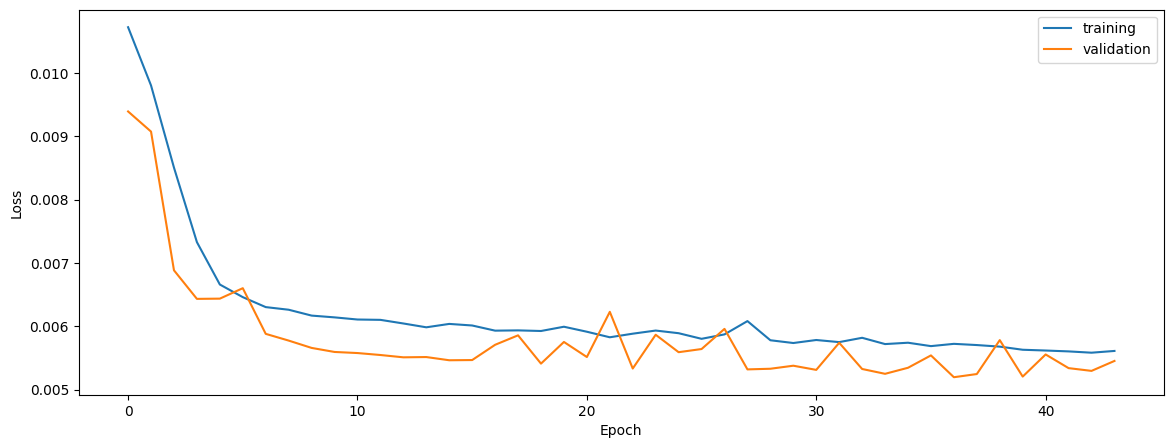

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.660661558588525
0.67083857390362
0.6138975945583708


In [8]:
print('native')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

native
0.660661558588525
0.67083857390362
0.6138975945583708


In [9]:
print('normalized')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

normalized
0.6644834634159859
0.6723958356285303
0.6297532905197919


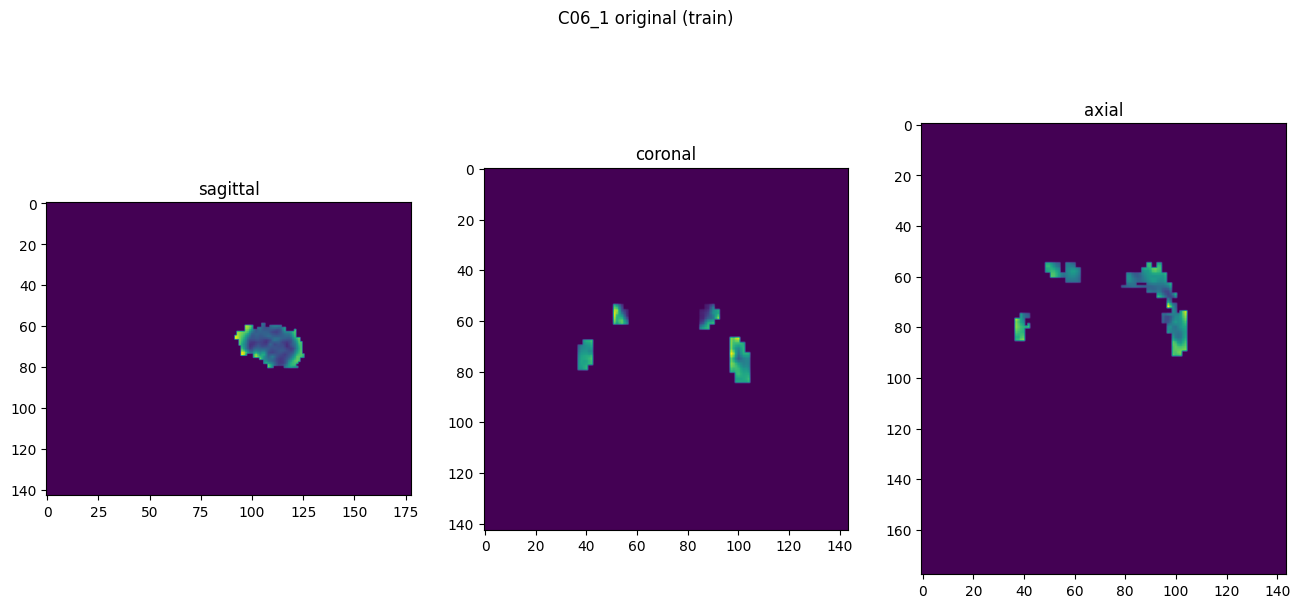

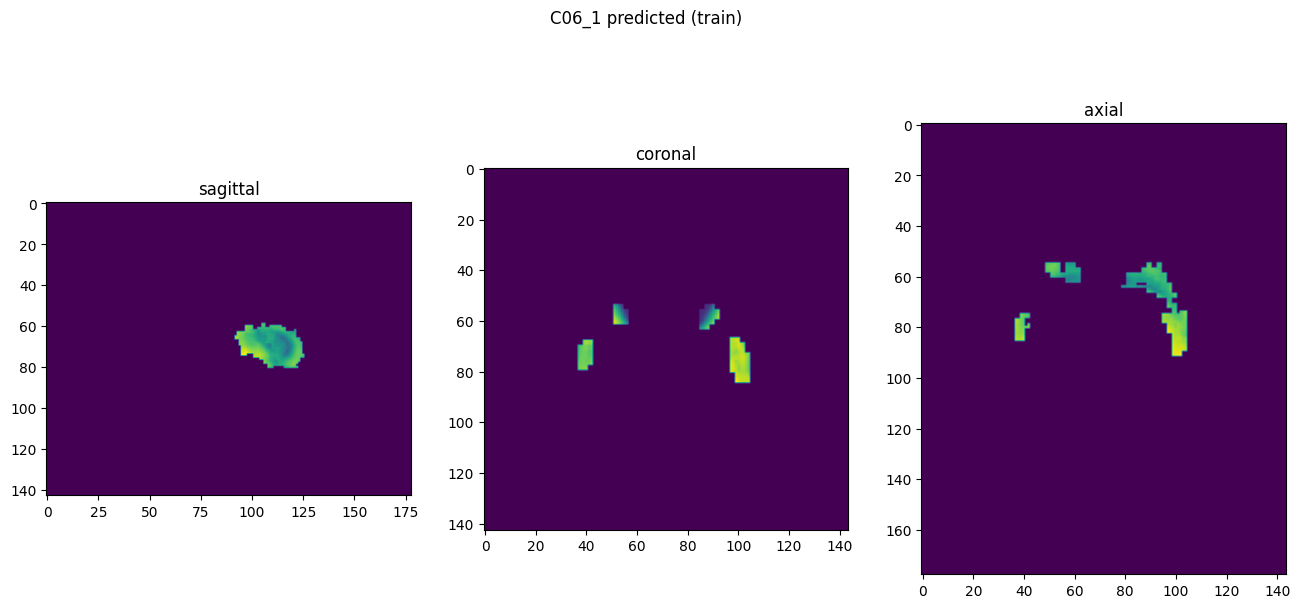

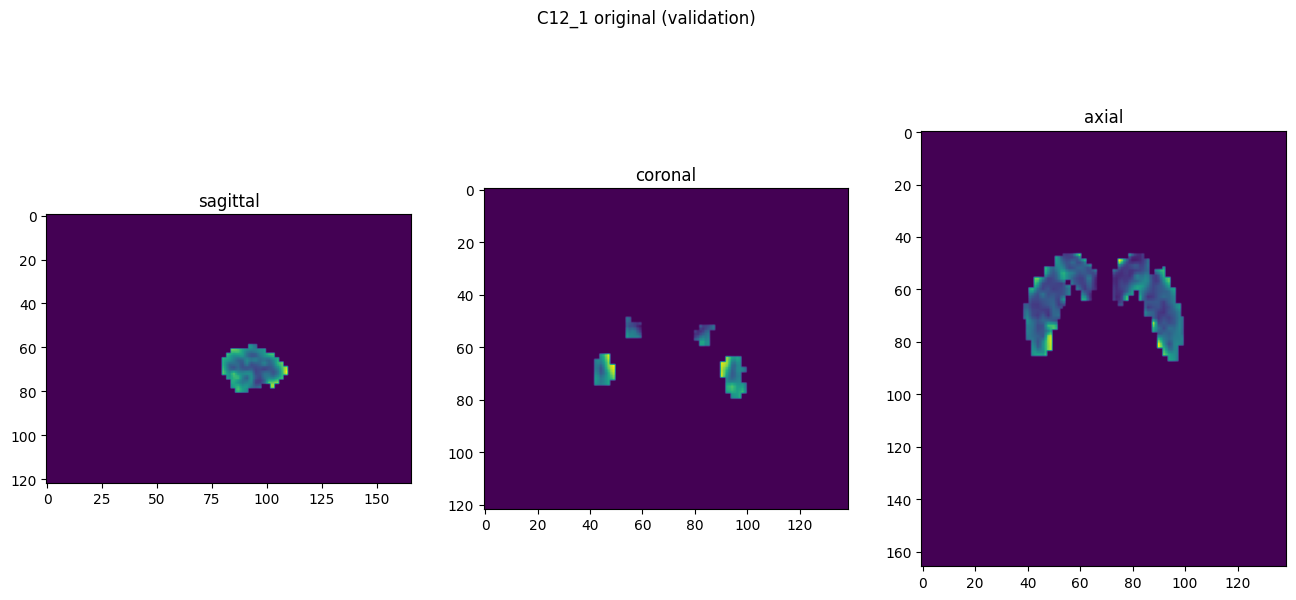

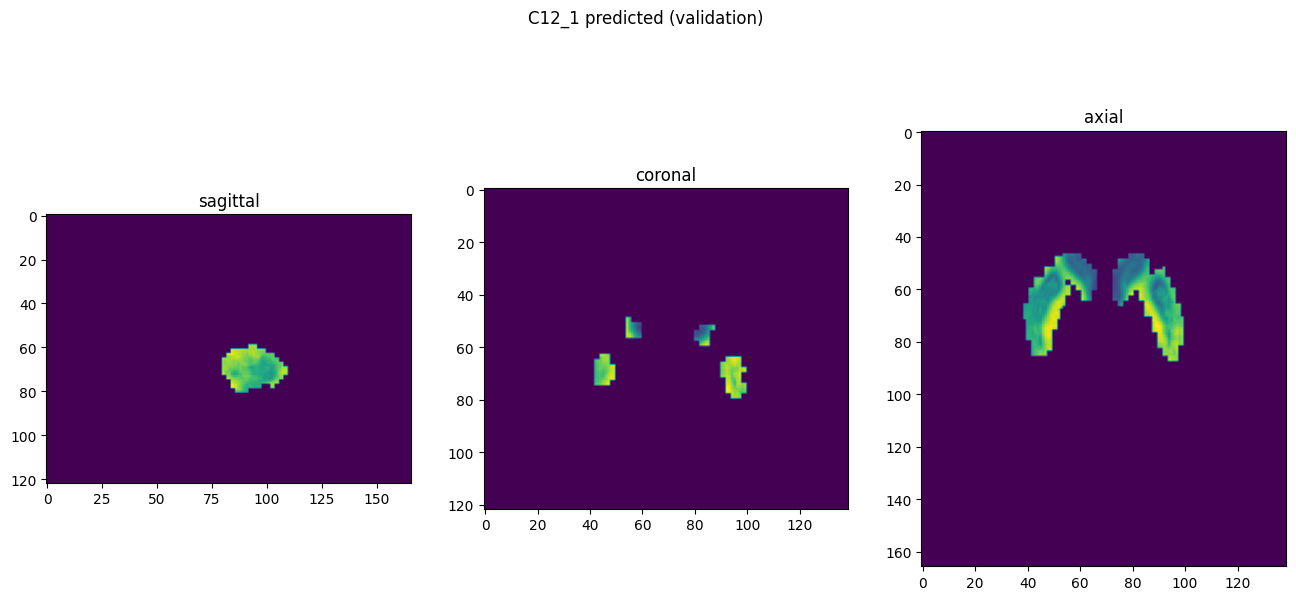

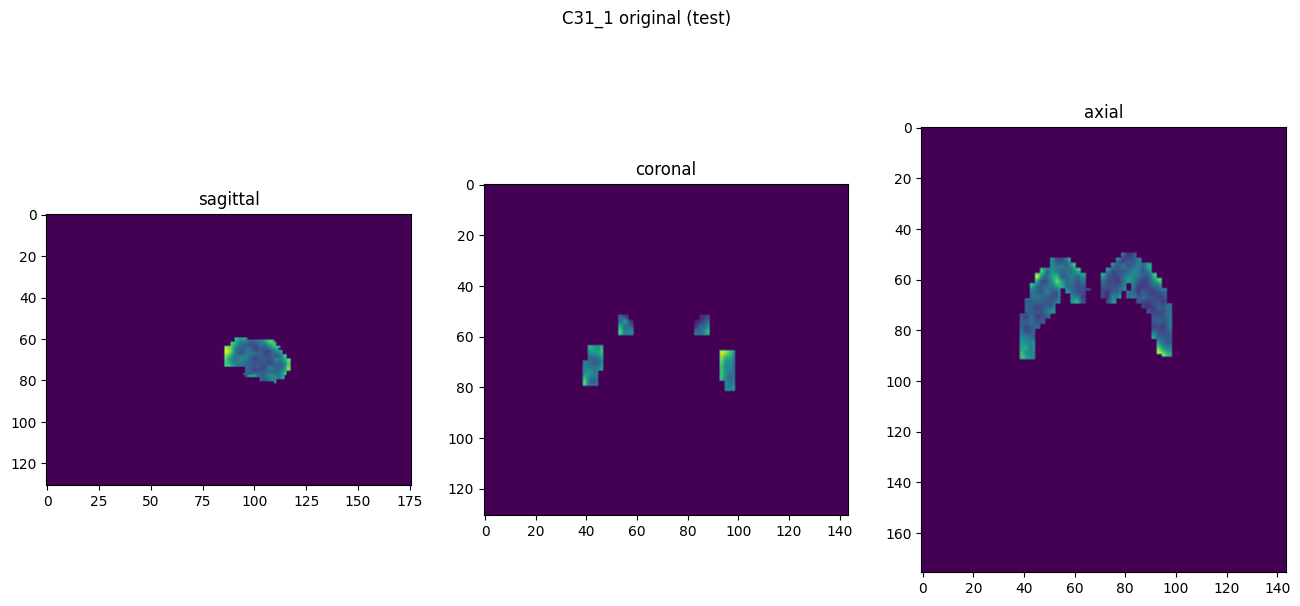

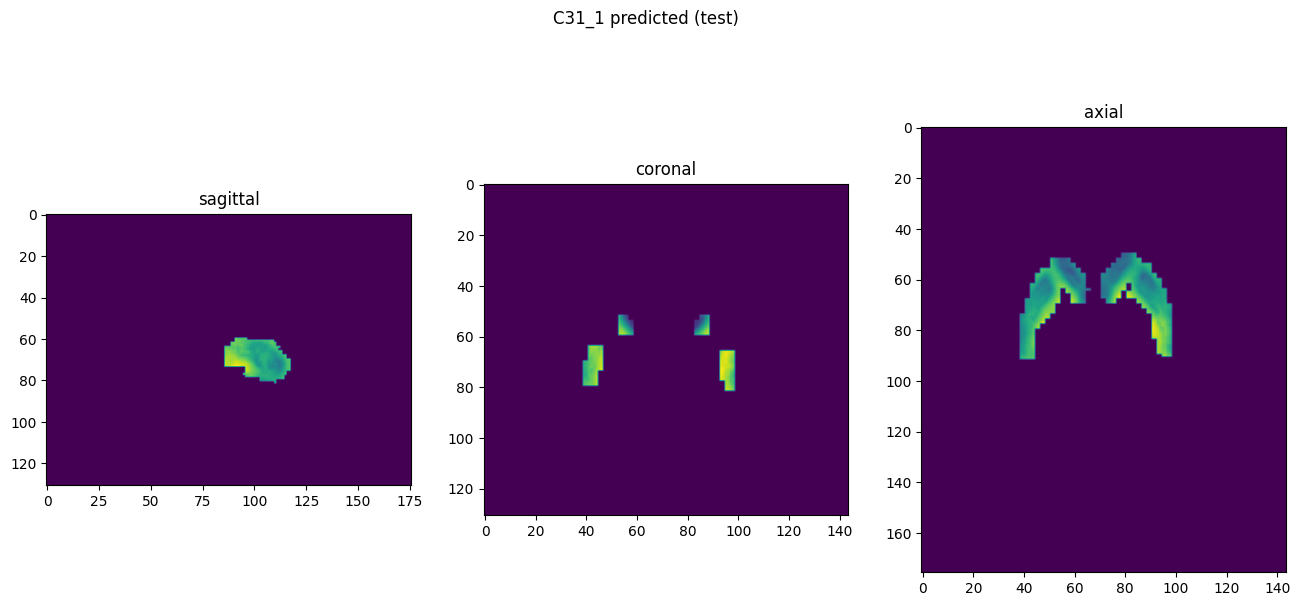

In [10]:
showResults(model, gen, threshold=None, background=False)